# Обучение моделей для прогноза оттока клиентов для телеком-компании.

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**Описание данных**

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- **contract** — информация о договорах;
- **personal** — персональные данные клиентов;
- **internet** — информация об интернет-услугах;
- **phone** — информация об услугах телефонии.

Таблица telecom.contract
- **customerID** — ID абонента;
- **BeginDate** — дата начала действия договора;
- **EndDate** — дата окончания действия договора;
- **Type** — тип оплаты: раз в год-два или ежемесячно;
- **PaperlessBilling** — электронный расчётный лист;
- **PaymentMethod** — тип платежа;
- **MonthlyCharges** — расходы за месяц;
- **TotalCharges** — общие расходы абонента.

Таблица personal
- **customerID** — ID пользователя;
- **gender** — пол;
- **SeniorCitizen** — является ли абонент пенсионером;
- **Partner** — есть ли у абонента супруг или супруга;
- **Dependents** — есть ли у абонента дети.

Таблица telecom.internet
- **customerID** — ID пользователя;
- **InternetService** — тип подключения;
- **OnlineSecurity** — блокировка опасных сайтов;
- **OnlineBackup** — облачное хранилище файлов для резервного копирования данных;
- **DeviceProtection** — антивирус;
- **TechSupport** — выделенная линия технической поддержки;
- **StreamingTV** — стриминговое телевидение;
- **StreamingMovies** — каталог фильмов.

Таблица telecom.phone
- **customerID** — ID пользователя;
- **MultipleLines** — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

## Знакомство с данными

### Определение и загрузка библиотек

In [1]:
#!pip install phik
#!pip install catboost
#!pip install torchmetrics
#!pip install --upgrade 'sqlalchemy<2.0'
#!pip install --upgrade ipykernel

In [2]:
import warnings
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from tqdm import notebook
from tqdm.auto import tqdm
tqdm.pandas()

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn import tree
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from functools import reduce
import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC

RANDOM_STATE = 18923
K_FOLDS = 5

In [3]:
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-final',
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'])

engine = create_engine(connection_string)

### Создание частоиспользуемых функций

In [4]:
def data_info(df):

    print(f'Информация о таблице {df.name}')
    print()
    display(df.head(7))
    print()
    print(df.info(memory_usage = 'deep'))
    print()
    display(df.describe().transpose())


def missing_values(data):

    '''Визуализация NaN значений в таблице'''

    nan_dict = {}
    for column in data:
        nan_dict[column] = data[column].isna().sum() / data.shape[0]

    df_nan = pd.DataFrame(data=list(nan_dict.values()),
                          index=list(nan_dict.keys()),
                          columns=['Процент пропущенных значений'])


    ### Построим barplot с NaN значениями
    plt.figure(figsize=(25,13))

    plots = sns.barplot(data=df_nan,
                        x=list(df_nan.index),
                        y = 'Процент пропущенных значений',
                        palette = 'coolwarm')
    plt.title(f'Процент и количество пропущенных значений в таблице {data.name}', fontsize=18)

    ### Поставим annot
    i = 0
    for bar in plots.patches:
        plots.annotate([format(bar.get_height(), '.1%'), data[data.columns[i]].isna().sum()],
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=10, xytext=(0, 8),
                       textcoords='offset points')
        i += 1


def eda(data):
    display(data.head())
    print(f'Размер таблицы: {data.shape}\n')
    print(f'Типы данных таблицы: \n{data.dtypes}\n')
    print(f'Пропусков в таблице: \n{data.isna().sum()}\n')
    print(f'Дубликатов в таблице: {data.duplicated().sum()}\n')
    for column in data.columns:
        print(f'Признак: {column} \nКол-во значений: \n{data[column].value_counts()}')
        print()

def data_spread(df, column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

    df.boxplot(column=column, ax=ax[0])
    ax[0].set_title(f'Диаграмма размаха на столбце {column}')
    ax[0].grid(True)

    ax[1].hist(df[column], bins=200)
    ax[1].set_title(f'Гистограмма на столбце {column}')
    ax[1].grid(True)

    fig.suptitle(f'Разброс данных столбца {column}')

    plt.show()
    print('    ', '-'*104)

def uniqueness(df, column_list):

    '''Просмотр уникальных значений листа'''

    for column in column_list:
        print(f'Количество уникальных значений столбца {column}: {df[column].nunique()}')
        print(df[column].unique())
        print('-----------------------------')

def check_client(index):
    month = contract.iloc[index]['TotalCharges'] // contract.iloc[index]['MonthlyCharges']
    year = 365// (contract.iloc[index]['TotalCharges'] // contract.iloc[index]['MonthlyCharges'])
    end = (contract.iloc[index]['BeginDate'].year + 365//
           (contract.iloc[index]['TotalCharges'] // contract.iloc[index]['MonthlyCharges']))
    print(f'Клиент: {index}')
    print(f'Месяцев использования: {month}')
    print(f'Лет использования: {year}')
    print(f'Год конца тарифа: {end}')
    print(f'Текущий год: {2023}')

def hist_box(data, col):
    fig,ax = plt.subplots(2,1, sharex=True, figsize=(6,6),
                          gridspec_kw={'height_ratios': [3, 1]})

    sns.histplot(data=data,x=col,bins=100,
                 ax=ax[0]).set(title=f'Распределение признака {col}')

    sns.boxplot(data=data, x=col, ax=ax[1])

    return plt.show();

### Загрузка данных

Распакуем каждую из сущностей в наши таблицы

Информация о таблице contract



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 2.4 MB
None



,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


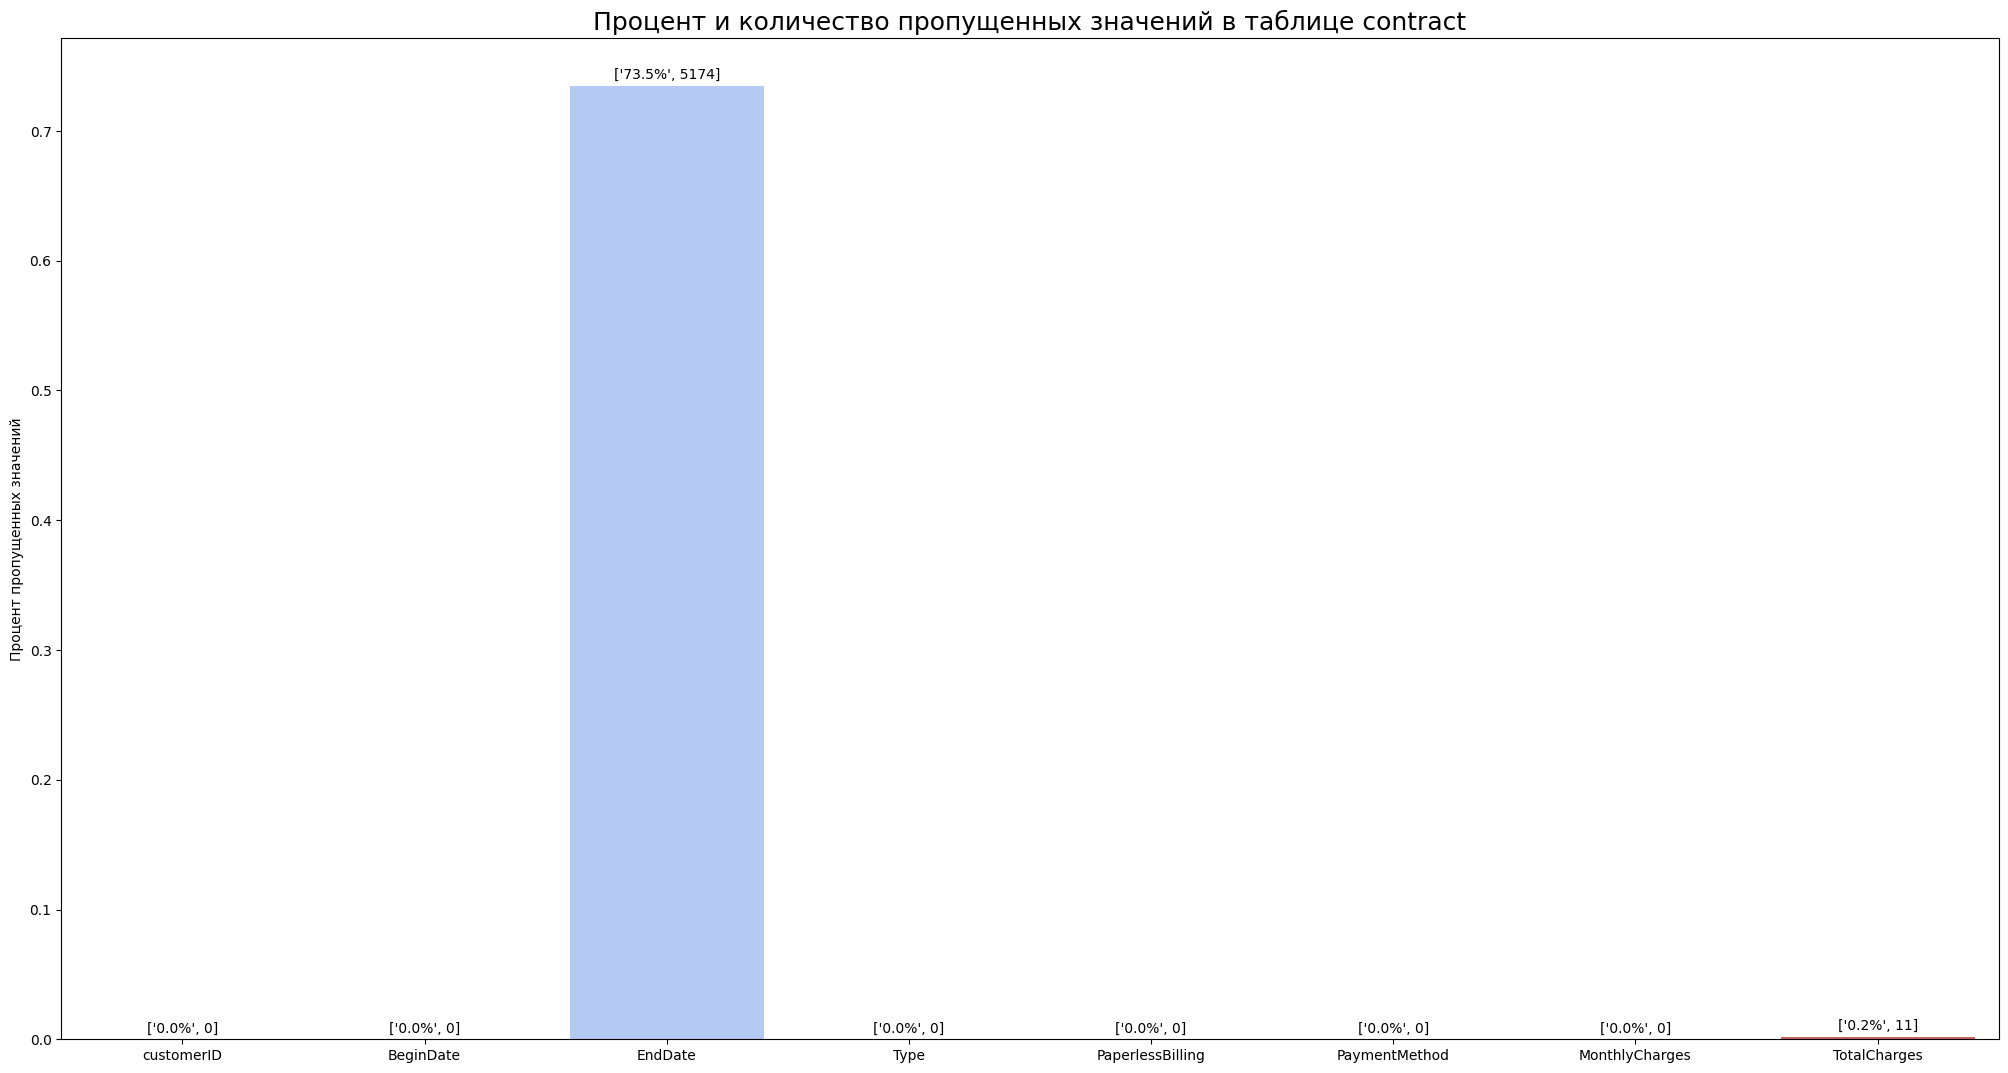

In [5]:
contract = '''
SELECT *
FROM telecom.contract
'''
contract = pd.read_sql_query(contract, con = engine)
contract.name = 'contract'

data_info(contract)
missing_values(contract)

Проверим, верно ли утверждение, что данные из столбца TotalCharges равны NaN в том случае, если человек стал пользователем компании в период сбора данных - 1 февраля 2020 года.

In [6]:
warnings.filterwarnings('ignore')

display(contract.loc[contract.TotalCharges.isna()])
print()
print((contract.loc[contract.TotalCharges.isna()].index == contract.loc[contract['BeginDate'] == pd.Timestamp('2020-02-01')].index).all())

warnings.filterwarnings('default')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN



True


In [7]:
personal = '''
SELECT *
FROM telecom.personal
'''
personal = pd.read_sql_query(personal, con = engine)
personal.name = 'personal'

data_info(personal)

Информация о таблице personal



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 1.7 MB
None



,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


In [8]:
internet = '''
SELECT *
FROM telecom.internet
'''
internet = pd.read_sql_query(internet, con = engine)
internet_columns = internet.iloc[0]
internet = internet[1:]
internet.columns = internet_columns
internet.name = 'internet'

data_info(internet)

Информация о таблице internet



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 2.6 MB
None



,count,unique,top,freq
0,,,,
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


In [9]:
phone = '''
SELECT *
FROM telecom.phone
'''
phone = pd.read_sql_query(phone, con = engine)
phone_columns = phone.iloc[0]
phone = phone[1:]
phone.columns = phone_columns
phone.name = 'phone'

data_info(phone)

Информация о таблице phone



,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 785.7 KB
None



,count,unique,top,freq
0,,,,
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


In [10]:
for dataset in [personal, internet, phone]:
    print(f'Количество уникальных ID клиентов в множестве contract и {dataset.name} =',
          len(set(contract['customerID']) & set(dataset['customerID'])))

print()
print(f'Количество уникальных ID клиентов в множестве phone и internet =',
          len(set(phone['customerID']) & set(internet['customerID'])))

Количество уникальных ID клиентов в множестве contract и personal = 7043
Количество уникальных ID клиентов в множестве contract и internet = 5517
Количество уникальных ID клиентов в множестве contract и phone = 6361

Количество уникальных ID клиентов в множестве phone и internet = 4835


### Вывод

Нам удалось подключится к базе данных и получить информацию из неё по 4 таблицам:
- contract — информация о договорах. Количество заключенных контрактов - 7043, всего 8 признаков. В таблице 5174 пропущенных значений в признаке EndDate (дата окончания действия договора) - это пользователи, которые не разорвали контракт. А также 11 нулевых значений в столбце TotalCharges (общие расходы абонента), данные пропущенные значения связаны лишь с теми людьми, которые сформировали договор с «ТелеДом» в последний день сбора данных ("Информация о договорах актуальна на 1 февраля 2020"), поэтому заполним пропуски нулевыми значениями. Наименования столбцов в порядке, но рекомендуется поменять тип данных столбцов BeginDate и EndDate на datetime[64].
- personal — персональные данные клиентов. Количество контрактов соотвествует персональным данным о клиентах - 7043, в таблице 5 признаков. Рекомендовано изменить тип данных в столбце SeniorCitizen (является ли абонент пенсионером) вместо int64 - object.
- internet — информация об интернет-услугах. Всего 5517 наблюдений и 8 признаков. Наименования столбцов в порядке, пропущенных значений не выявлено.
- phone — информация об услугах телефонии. Состоит из 6361 наблюдения и 2 признаков. Признак customerID появляется в каждой таблице.

Для дальнейшей работы необходимо учитывать:
- Пересечение множества значений customerID из столбца internet и phone даст нам 4835 значений - клиенты, которые пользуются и интернетом, и телефонной связью вместе.
Это означает, что не все пользователи пользуются двумя услугами одновременно. Пересечение contract и internet даст нам 5517 значений, а contract и phone - 6361 значение.
Поэтому при дальнейшем объединении всех 4 таблиц нужно будет заполнять пропущенные значения определённым типом "Без интернета" или "Без телефонной связи".
- Возможно, в таблице contract итоговая сумма за пользование рассчитывается некорректно, так как у клиента 3668-QPYBK, который использовал услуги более года, однако сумма соответствует 2 месяцам.

## Предобработка данных

Проведем исследовательский анализ данных: проверим наличие пропусков и аномалий, изучим распределение признаков.<br/>
Аномалии обработаем с учётом особенностей услуг телекоммуникации.

### Таблица contract

In [11]:
eda(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Размер таблицы: (7043, 8)

Типы данных таблицы: 
customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

Пропусков в таблице: 
customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

Дубликатов в таблице: 0

Признак: customerID 
Кол-во значений: 
4472-LVYGI    1
6137-NICCO    1
8387-UGUSU    1
7714-YXSMB    1
6872-HXFNF    1
             ..
4723-BEGSG    1
2731-GJRDG    1
2001-MCUUW    1
1096-ADRUX    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

Признак: BeginDate 
Кол-во значений: 
2019-03-24    43
2019-03-13    43
2019-04-03    41
2019-04-08    41
2019-03-09    41
              ..
2018-06-07     1
2018-07-18     1
2018-08-02     1

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


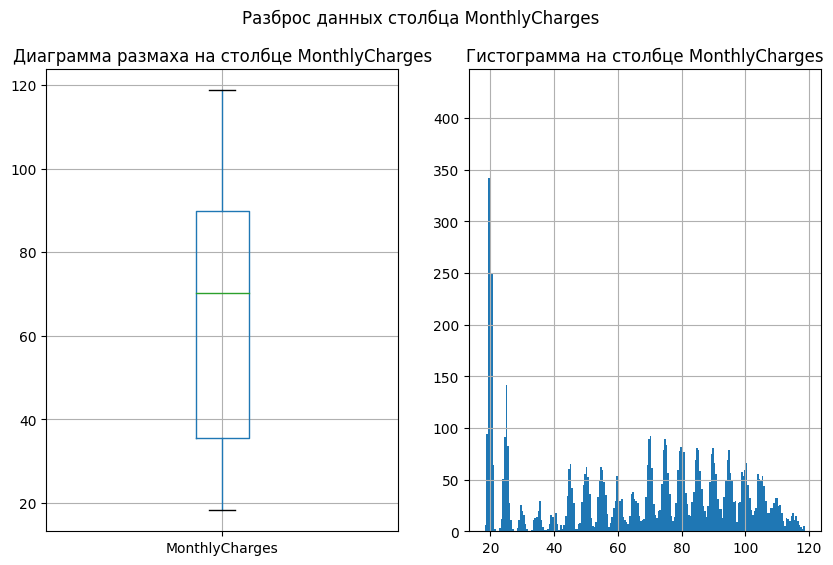

     --------------------------------------------------------------------------------------------------------


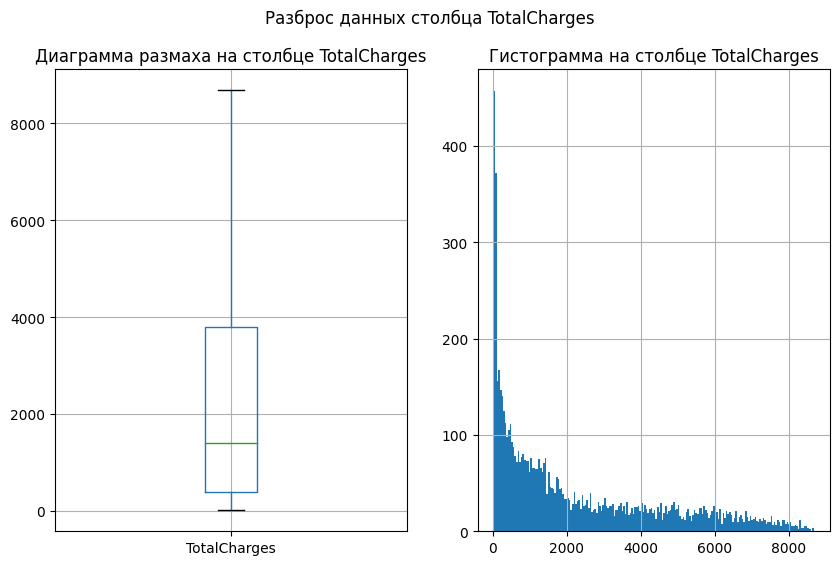

     --------------------------------------------------------------------------------------------------------


In [12]:
# Разброс данных
for column in ['MonthlyCharges', 'TotalCharges']:
    data_spread(contract, column)

Исправим пропущенные значения по столбцу TotalCharges и посмотрим уникальные значения категориальных признаков.

In [13]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)
contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
dtype: int64

In [14]:
uniqueness(contract, ['Type', 'PaperlessBilling', 'PaymentMethod'])

Количество уникальных значений столбца Type: 3
['Two year' 'Month-to-month' 'One year']
-----------------------------
Количество уникальных значений столбца PaperlessBilling: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца PaymentMethod: 4
['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']
-----------------------------


Проверим аномалии, например, клиенты которые не расторгли договор, но итоговая сумма посчитана.

In [15]:
contract[(contract['EndDate'].isna()) & (contract['TotalCharges']>0)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
280,1106-HRLKZ,2019-01-28,None,Two year,No,Mailed check,19.60,808.95
546,2430-RRYUW,2019-04-03,None,One year,Yes,Mailed check,54.80,3465.70
605,8879-XUAHX,2019-04-19,None,Two year,Yes,Electronic check,116.25,8564.75
841,8631-XVRZL,2019-01-26,None,One year,Yes,Mailed check,20.15,163.70
878,4324-BZCKL,2019-08-15,None,Month-to-month,Yes,Mailed check,55.55,551.30
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


In [16]:
check_client(280)

Клиент: 280
Месяцев использования: 41.0
Лет использования: 8.0
Год конца тарифа: 2027.0
Текущий год: 2023


In [17]:
check_client(546)

Клиент: 546
Месяцев использования: 63.0
Лет использования: 5.0
Год конца тарифа: 2024.0
Текущий год: 2023


In [18]:
check_client(605)

Клиент: 605
Месяцев использования: 73.0
Лет использования: 5.0
Год конца тарифа: 2024.0
Текущий год: 2023


У нас существуют 2 проблемы:
 - Клиент ушел, и у нас пропущенное в EndDate
 - Клиент не ушел, и у нас ошибка в TotalCharges

Проверка показала, что у клиентов договоры с известной датой окончания, которая еще не наступила, поэтому предлагаю оставить этих клиентов, как активных.

Признак MonthlyCharges - имеет множество пиковых зон, связанных с ежемесячным платежём, а разбросы рядом с ними - дополнительные затраты пользователей в месяц. Выбросы не определяются, медиана находится в районе значения 70, при этом данные в большинстве своём находятся в диапазоне от 35 до 90.

Распределение признака TotalCharges находится в диапазоне (0, 8684], плавно убывает в сторону увеличения. В данных отсутствуют выбросы, медиана распределена в районе 1600, а большинство значений находятся в диапазоне от 300 до 3900. Подобное распределение обусловленно длительностью договора, с увеличением продолжительности которого, больше сумма затрат.
Все остальные столбцы - категориальные, неявных дубликатов не выявлено.

### Таблица personal

In [19]:
eda(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Размер таблицы: (7043, 5)

Типы данных таблицы: 
customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

Пропусков в таблице: 
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Дубликатов в таблице: 0

Признак: customerID 
Кол-во значений: 
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

Признак: gender 
Кол-во значений: 
Male      3555
Female    3488
Name: gender, dtype: int64

Признак: SeniorCitizen 
Кол-во значений: 
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Признак: Partner 
Кол-во значений: 
No     3641
Yes    3402
Name: Partner, dtype: int64

Признак: Dependents 
Кол-во значений: 
No     4933
Yes    2110
Name: Dependents, dtype: int64



Посмотрим на уникальные значения категориальных признаков

In [20]:
uniqueness(personal, personal.columns.drop('customerID'))

Количество уникальных значений столбца gender: 2
['Female' 'Male']
-----------------------------
Количество уникальных значений столбца SeniorCitizen: 2
[0 1]
-----------------------------
Количество уникальных значений столбца Partner: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца Dependents: 2
['No' 'Yes']
-----------------------------


Пропусков в данной таблице нет
Мужчин и женщин, которые пользуются данным оператором практически одинаково.
В датасете преимущественно клиенты трудоспособного возраста.
Количество абонентов в браке и не в браке практически совпадает.
Однако большая часть клиентов не имеют детей.

### Таблица internet

In [21]:
eda(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


Размер таблицы: (5517, 8)

Типы данных таблицы: 
0
customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

Пропусков в таблице: 
0
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Дубликатов в таблице: 0

Признак: customerID 
Кол-во значений: 
7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: customerID, Length: 5517, dtype: int64

Признак: InternetService 
Кол-во значений: 
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Признак: OnlineSecurity 
Кол-во значений: 
No     3498
Yes    2019
Name: OnlineSecurity, dtype: i

Посмотрим на уникальные значения категориальных признаков

In [22]:
uniqueness(internet, internet.columns.drop('customerID'))

Количество уникальных значений столбца InternetService: 2
['DSL' 'Fiber optic']
-----------------------------
Количество уникальных значений столбца OnlineSecurity: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца OnlineBackup: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца DeviceProtection: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца TechSupport: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца StreamingTV: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца StreamingMovies: 2
['No' 'Yes']
-----------------------------


Клиенты "ТелеДома" предпочитают тип подключения Fiber optic.<br/>
У большего количества пользователей не установлена блокировка опасных сайтов.<br/>
Облачное хранилище файлов для резервного копирования данных использует менее 2500 абонентов.<br/>
Антивирус для своего устройства подключили более 2000 клиентов.<br/>
У большего количества пользователей нет выделенной линии технической поддержки.<br/>
Количество пользователей, которые подключили стриминговое телевидение и каталог фильмов практически совпадает с теми, кто от этих услуг отказался.<br/>

### Таблица phone

In [23]:
eda(phone)

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


Размер таблицы: (6361, 2)

Типы данных таблицы: 
0
customerID       object
MultipleLines    object
dtype: object

Пропусков в таблице: 
0
customerID       0
MultipleLines    0
dtype: int64

Дубликатов в таблице: 0

Признак: customerID 
Кол-во значений: 
5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: customerID, Length: 6361, dtype: int64

Признак: MultipleLines 
Кол-во значений: 
No     3390
Yes    2971
Name: MultipleLines, dtype: int64



Посмотрим на уникальные значения категориальных признаков

In [24]:
uniqueness(phone, phone.columns.drop('customerID'))

Количество уникальных значений столбца MultipleLines: 2
['No' 'Yes']
-----------------------------


Непрерывных данных нет, также как и пропусков в данной таблице нет
Клиенты преимущественно не пользуются услугой подключения к нескольким линиям одновременно.

### Объединение таблицы по ID клиента

Каждому клиенту должно соответствовать одно наблюдение. При объединении учитывайте особенности услуг телекоммуникации.

In [25]:
data = reduce(lambda left, right: pd.merge(left,right,on=['customerID'], how='outer'),
              [contract, personal, internet, phone])

In [26]:
data.name = 'data'
data_info(data)

Информация о таблице data



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,0.00,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,0.00,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,0.00,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00


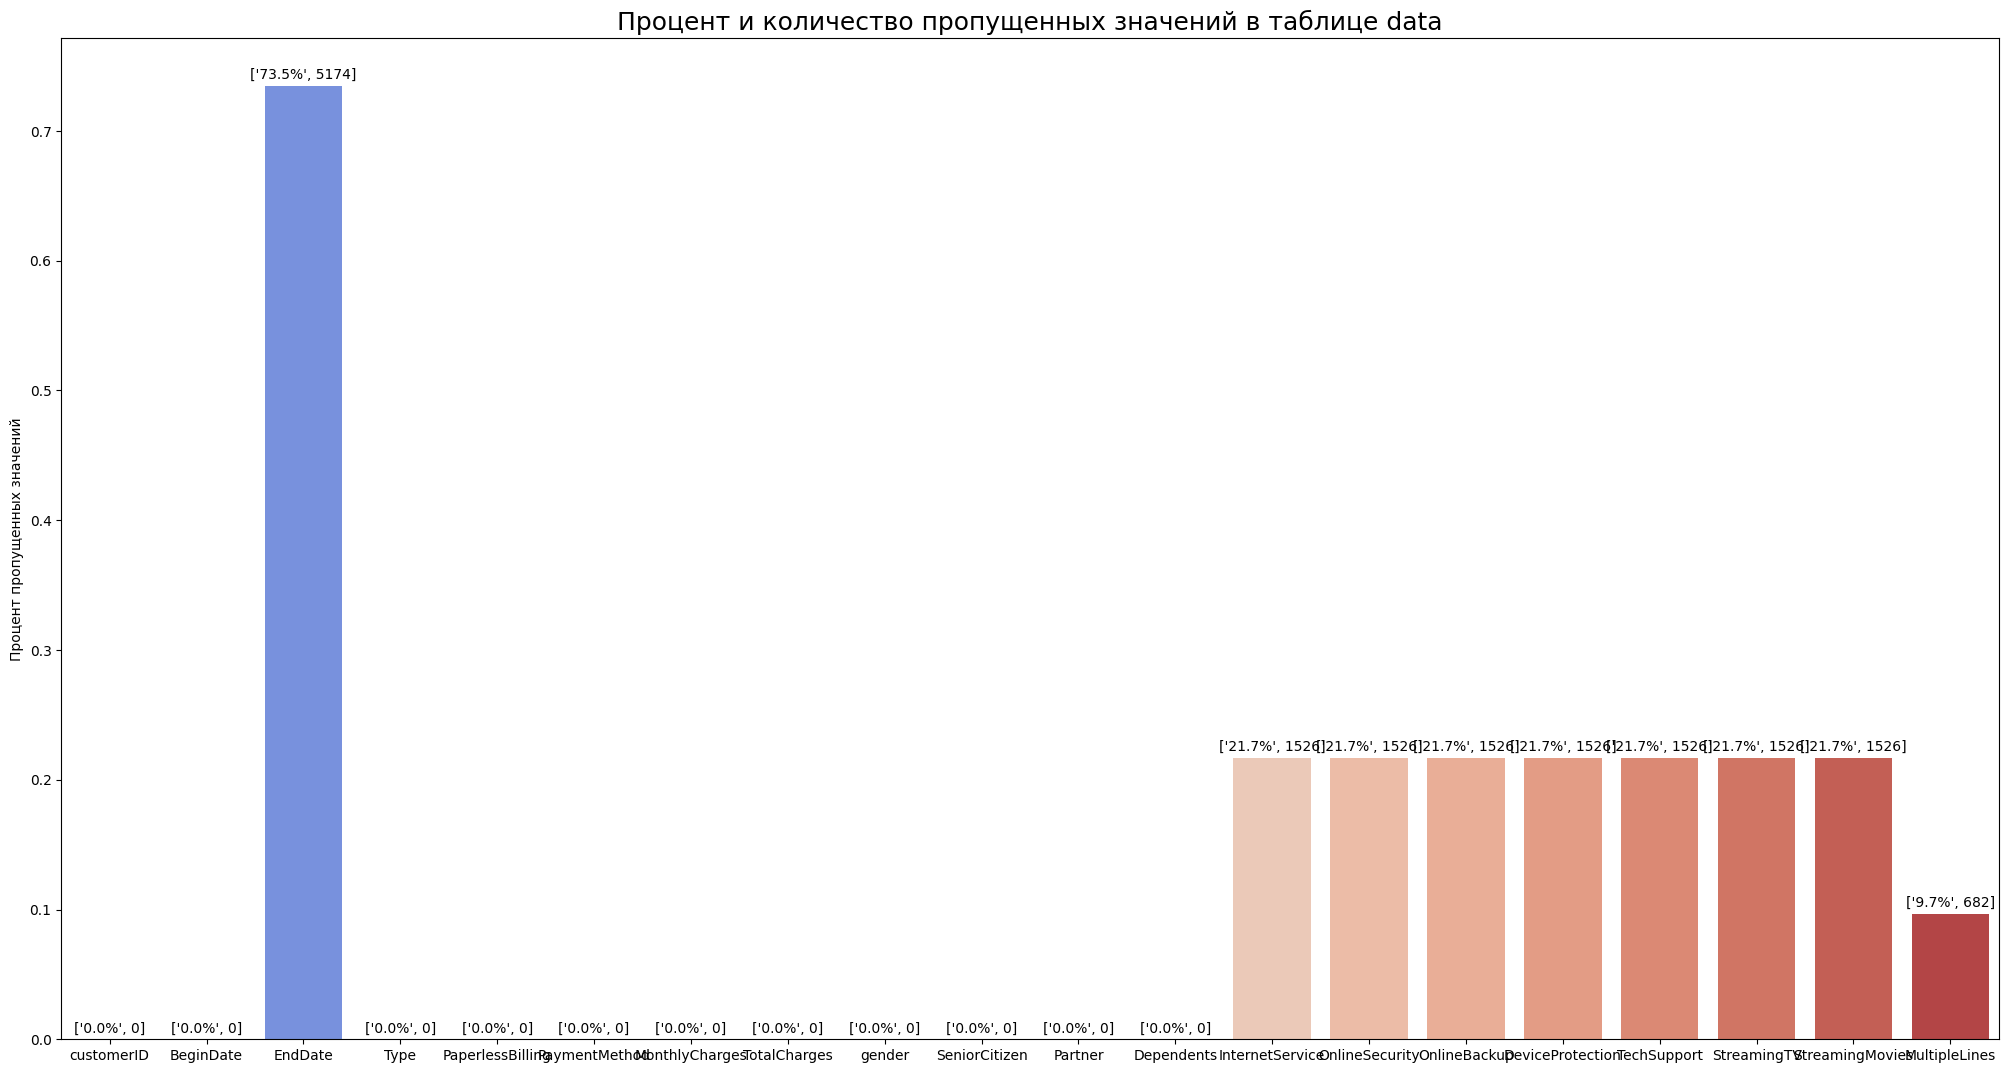

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [27]:
missing_values(data)

In [28]:
print('Размер после объединения:', data.shape)
print('Кол-во уникальных пользователей:', len(set(data['customerID'])))
display(data.head())
print(f'Кол-во пропусков: \n{data.isna().sum()}')

Размер после объединения: (7043, 20)
Кол-во уникальных пользователей: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,0.00,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,0.00,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Кол-во пропусков: 
customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


После объединения всех таблиц в один датафрейм у нас получилось 20 столбцов, 7043 наблюдения. С пропущенными значениями будем разбираться в следующем пункте, как мы выяснили, они появились из-за того, что не все пользователи пользуются и интернетом, и телефонной связью одновременно.
Попробуем сгенерировать новые признаки, которые могут пригодиться при обучении. Например, рассчитайте длительность контракта абонента, используя столбцы с датами.

### Преобразование целевой переменной

Преобразуем столбец EndDate в целевую переменную.

In [29]:
def target_markeup(row):

    if row['EndDate'] is None:
        return 0
    return 1

data['target'] = data.progress_apply(target_markeup, axis=1)

/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/7043 [00:00<?, ?it/s]

Заполним пропущенные значения, которые появились при объединении сущностей
- no_internet - без интернета
- no_phone - без телефонной связи

In [30]:
no_internet = ['MultipleLines']
no_phone = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

data[no_internet] = data[no_internet].fillna('no_internet')
data[no_phone] = data[no_phone].fillna('no_phone')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Поменяем тип данных с int на object в столбце SeniorCitizen

In [31]:
data.loc[data['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
data.loc[data['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

data.SeniorCitizen.unique()

array(['No', 'Yes'], dtype=object)

### Формирование новых признаков

Сформируем новый признак количество дней пользования тарифом. Если контракт не разорван - ограничиваемся дедлайном

In [32]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['EndDate'] = data['EndDate'].fillna(pd.to_datetime('01-02-2020', format='%d-%m-%Y'))
data['contract_duration'] = (data['EndDate'] - data['BeginDate']).dt.days

data.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,contract_duration
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,No,...,DSL,Yes,No,Yes,Yes,Yes,No,no_internet,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,Male,No,...,no_phone,no_phone,no_phone,no_phone,no_phone,no_phone,no_phone,No,0,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,...,DSL,Yes,Yes,No,No,No,No,No,1,479


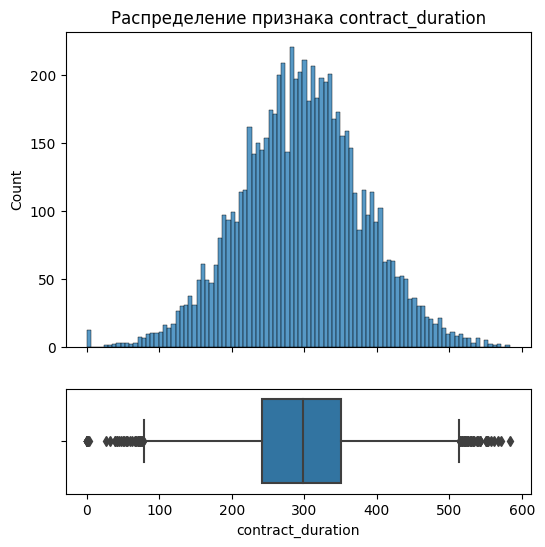

In [33]:
hist_box(data, 'contract_duration')

Подсчитаем количество дней, которые остались до оплаты пользования за следующий период

In [34]:
def days_before_payment(row):
    if row['Type'] == 'Month-to-month':
        return row['contract_duration'] % 30
    elif row['Type'] == 'One year':
        return row['contract_duration'] % 366
    return row['contract_duration'] % 732

data['days_bp'] = data.progress_apply(days_before_payment, axis=1)
data.head(3)

/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/7043 [00:00<?, ?it/s]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,contract_duration,days_bp
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,No,...,Yes,No,Yes,Yes,Yes,No,no_internet,0,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,Male,No,...,no_phone,no_phone,no_phone,no_phone,no_phone,no_phone,No,0,0,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,...,Yes,Yes,No,No,No,No,No,1,479,29


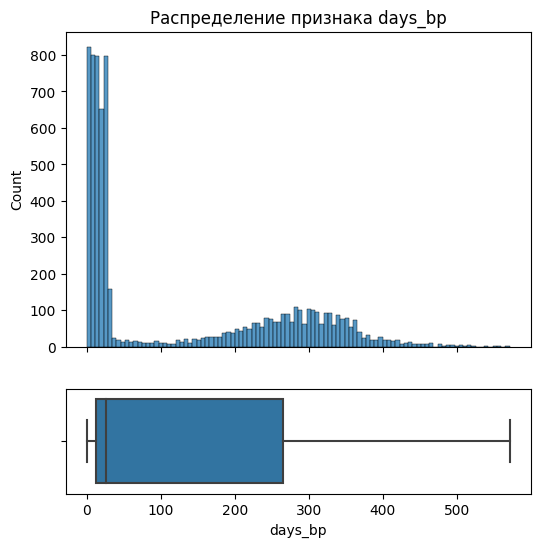

In [35]:
hist_box(data, 'days_bp')

Посчитаем отношение общей суммы затрат к числу дней действия договора.

In [36]:
data['charges_ratio'] = data['TotalCharges'] / data['contract_duration']
data['charges_ratio'] = data['charges_ratio'].fillna(0)
data.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,contract_duration,days_bp,charges_ratio
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,No,...,No,Yes,Yes,Yes,No,no_internet,0,0,0,0.000000
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,Male,No,...,no_phone,no_phone,no_phone,no_phone,no_phone,No,0,0,0,0.000000
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,...,Yes,No,No,No,No,No,1,479,29,0.225783


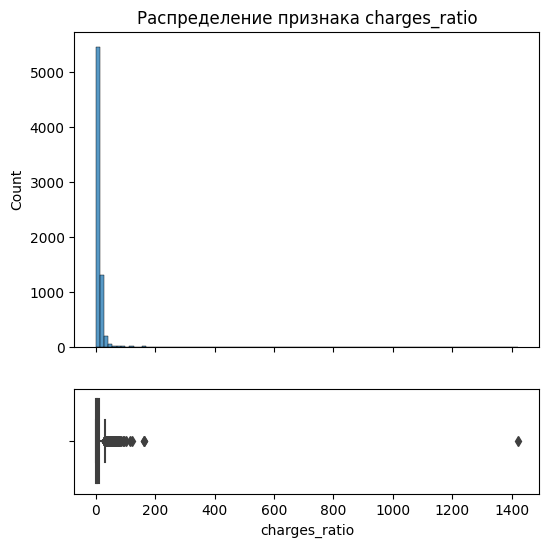

In [37]:
hist_box(data, 'charges_ratio')

Удалим признаки, которые нам больше не понадобятся.

In [38]:
del data['BeginDate']
del data['EndDate']
del data['customerID']
del data['TotalCharges']

data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               7043 non-null   object 
 1   PaperlessBilling   7043 non-null   object 
 2   PaymentMethod      7043 non-null   object 
 3   MonthlyCharges     7043 non-null   float64
 4   gender             7043 non-null   object 
 5   SeniorCitizen      7043 non-null   object 
 6   Partner            7043 non-null   object 
 7   Dependents         7043 non-null   object 
 8   InternetService    7043 non-null   object 
 9   OnlineSecurity     7043 non-null   object 
 10  OnlineBackup       7043 non-null   object 
 11  DeviceProtection   7043 non-null   object 
 12  TechSupport        7043 non-null   object 
 13  StreamingTV        7043 non-null   object 
 14  StreamingMovies    7043 non-null   object 
 15  MultipleLines      7043 non-null   object 
 16  target             7043 

Исследуем дисбаланс классов.

In [39]:
data['target'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: target, dtype: float64

### Вывод

По итогам предобработки данных мы не потеряли данные. Пропущенные значения, которые появились после объединения всех 4 таблиц мы заполнили следующим образом: no_internet - без интернета, no_phone - без телефонной связи.

После определения целевой переменной обнаружен дисбаланс классов 73%/27%, что в дальнейшей работе потребует исправлению.
Столбцы даты и времени были удалены вместе с ID клиента, вместо двух первых были добавлены новые, более информативные для обучения данные:
- contract_duration - количество дней действия контракта.
- days_bp - количество дней до оплаты тарифа
- charges_ratio - отношение общей суммы затрат к числу дней действия договора.

## Исследовательский анализ данных

### Phik-корреляция

Проведем исследовательский анализ данных объединённой таблицы, в котором уже не содержится пропусков и визуализируем распределение каждого признака.
Также визуализируем соотношение ушедших и оставшихся клиентов для каждого признака и проведем корреляционный анализ.

Сначала посмотрим, как распределена наша целевая переменная внутри каждого признака. У нас много категориальных переменных, поэтому для корреляционного анализа будем использовать Phik.

In [40]:
phik_overview = data.phik_matrix(interval_cols=['MonthlyCharges', 'charges_ratio', 'contract_duration', 'days_bp'])
phik_overview.round(2)
print('Матрица корреляции Phik')

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

Матрица корреляции Phik


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [41]:
def violentplot(df, column, target):
    plt.figure(figsize = (8, 5))
    sns.violinplot(
        x = target,
        y = column,
        data = df,
        kind = "violin",
        split = True,
        palette = "coolwarm"
    )
    plt.show()

    if df[column].nunique() <= 25:
        plt.figure(figsize = (12, 10))
        sns.histplot(data=df,
                     x=column,
                     binwidth=1,
                     hue=target)
        plt.show()

    print()
    print('Корреляция Phik:', np.round(phik_overview.loc[column]['target'], 2))
    print('-----------------------------------------------------------------------------------------------')
    print()

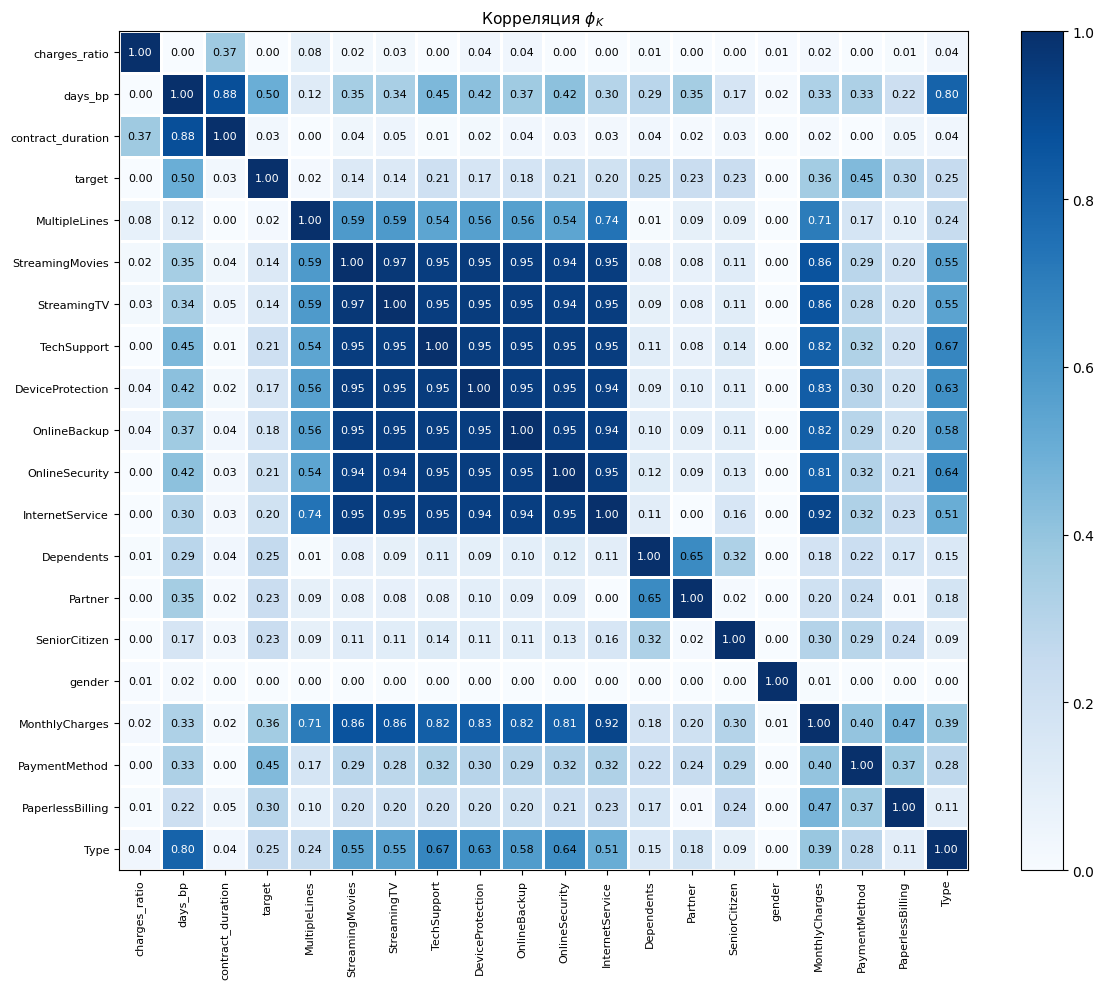

In [42]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Корреляция $\phi_K$",
                        fontsize_factor=0.8,
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

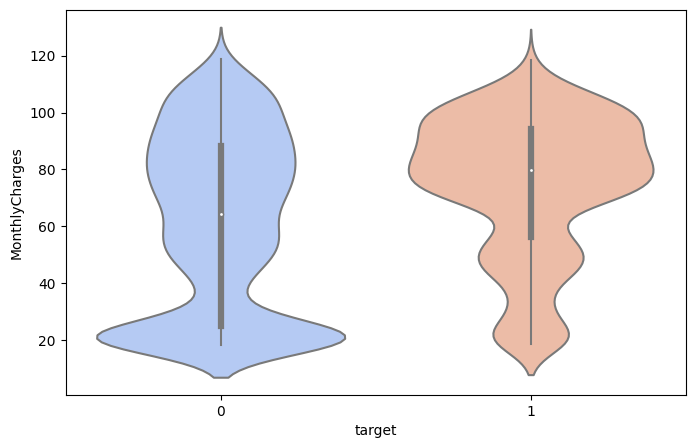


Корреляция Phik: 0.36
-----------------------------------------------------------------------------------------------



In [43]:
violentplot(data, 'MonthlyCharges', 'target')

Мы можем наблюдать, что клиент чаще всего уходит при высоких ежемесячных платежах. Большинство людей, которые не разорвали договор с компанией платят 20 у.е, но как только планка поднимается до 80 - вероятность расторжения договора повышается. У данного признака слабая зависимость с нашей целевой переменной.

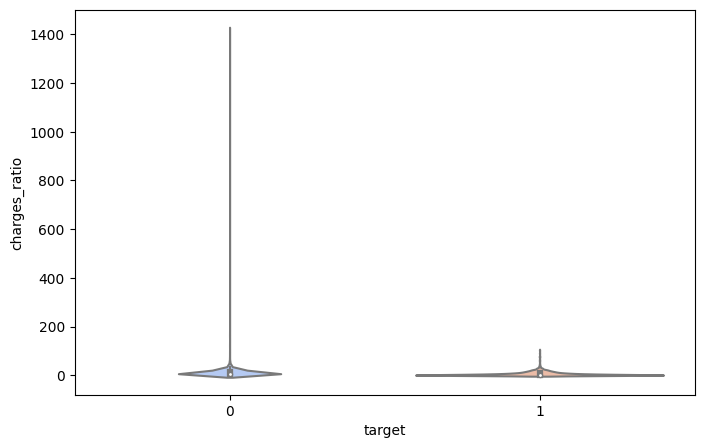


Корреляция Phik: 0.0
-----------------------------------------------------------------------------------------------



In [44]:
violentplot(data, 'charges_ratio', 'target')

Наблюдается высокая зависимость равная 85%, данный график может говорить о том, что человек уходит от компании, если за время пользования тарифом общая сумма превышает его внутренний максимум. Если тариф полностью покрывает необходимости клиента - он им пользуется на протяжении долгого времени.

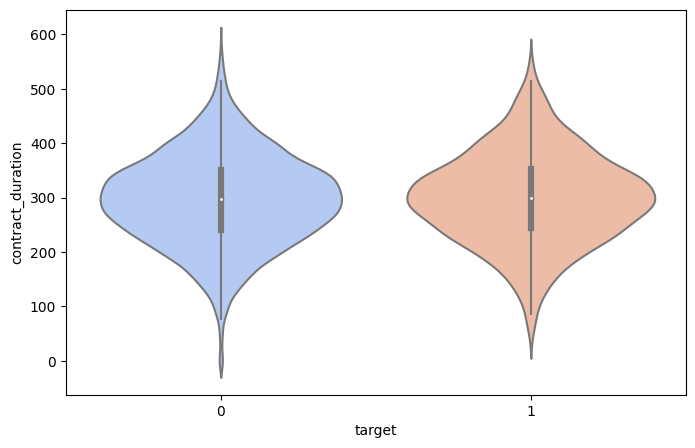


Корреляция Phik: 0.03
-----------------------------------------------------------------------------------------------



In [45]:
violentplot(data, 'contract_duration', 'target')

Данные нового добавленного столбца независимы между собой. Созданный признак не оправдал ожиданий.

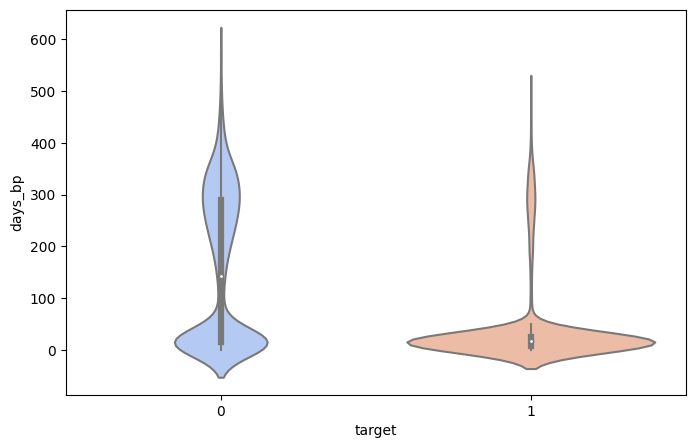


Корреляция Phik: 0.5
-----------------------------------------------------------------------------------------------



In [46]:
violentplot(data, 'days_bp', 'target')

Признак days_bp - количество дней, которые остались до оплаты следующего периода тарифа. Достаточно хороший показатель, который имеет умеренную зависимость. Пользователи чаще всего отказываются от тарифа в последние дни, перед следующей оплатой.

In [47]:
def spread(table, drops):
    table = table.drop([*drops], axis=1)
    col = table.columns[:-3]
    for feature in col:
        sns.set(rc={'figure.figsize':(10,5)})
        print(f'Зависимость целевого от признака: {feature}')
        sns.countplot(x = feature, hue='target', data=table)

        plt.show()
        print()
        print('Корреляция Phik:', np.round(phik_overview.loc[feature]['target'], 2))
        print('-----------------------------------------------------------------------------------------------')

Зависимость целевого от признака: Type


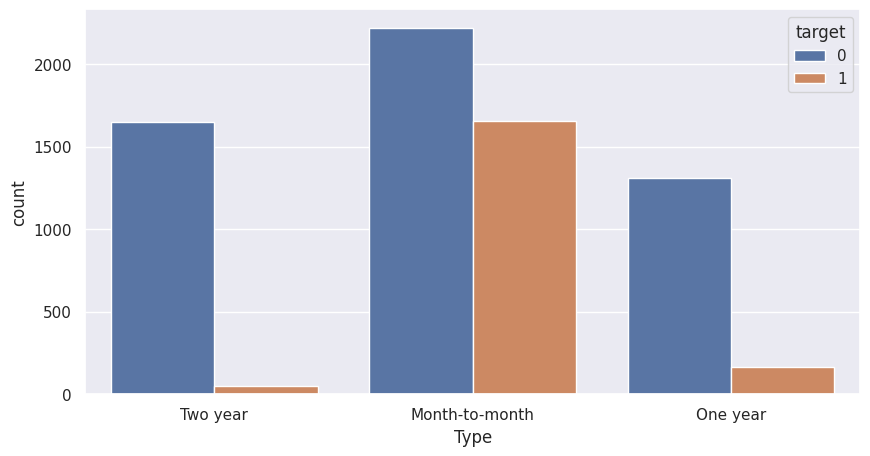


Корреляция Phik: 0.25
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: PaperlessBilling


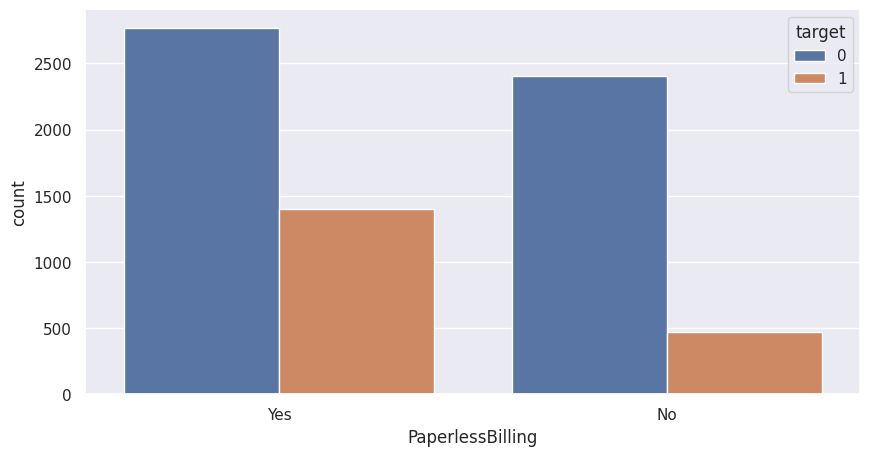


Корреляция Phik: 0.3
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: PaymentMethod


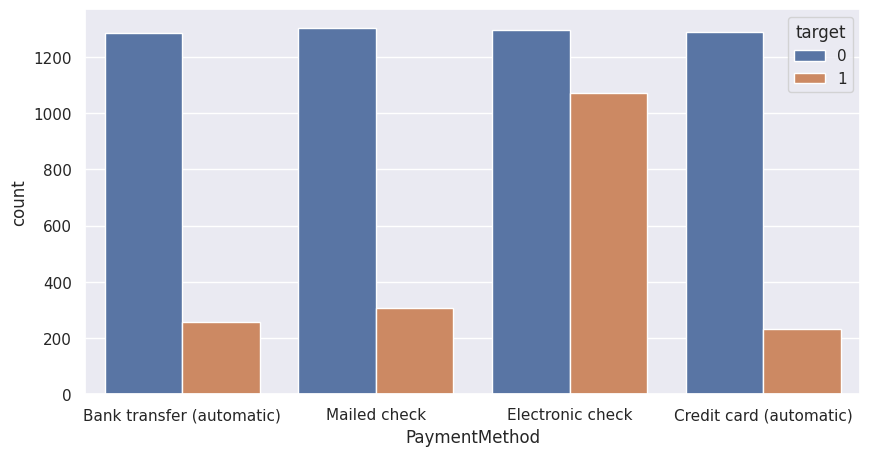


Корреляция Phik: 0.45
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: gender


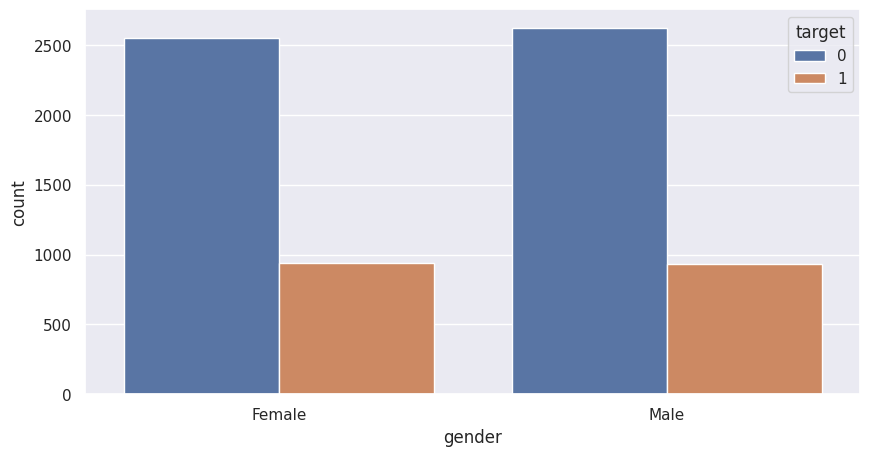


Корреляция Phik: 0.0
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: SeniorCitizen


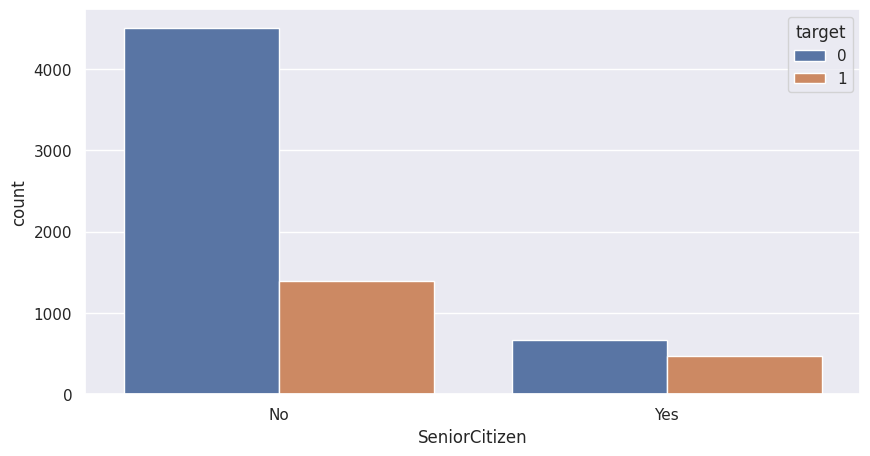


Корреляция Phik: 0.23
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: Partner


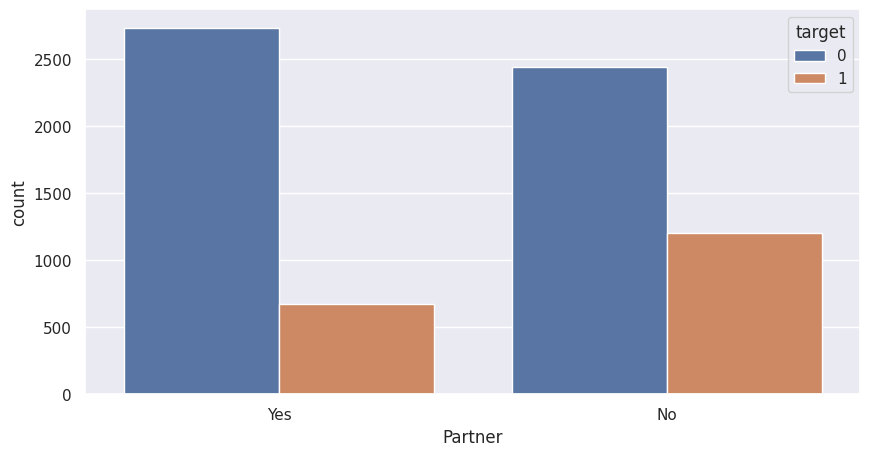


Корреляция Phik: 0.23
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: Dependents


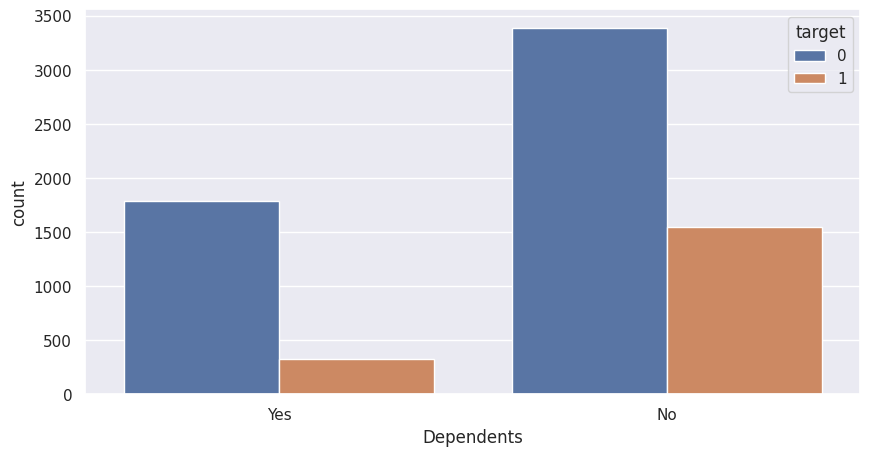


Корреляция Phik: 0.25
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: InternetService


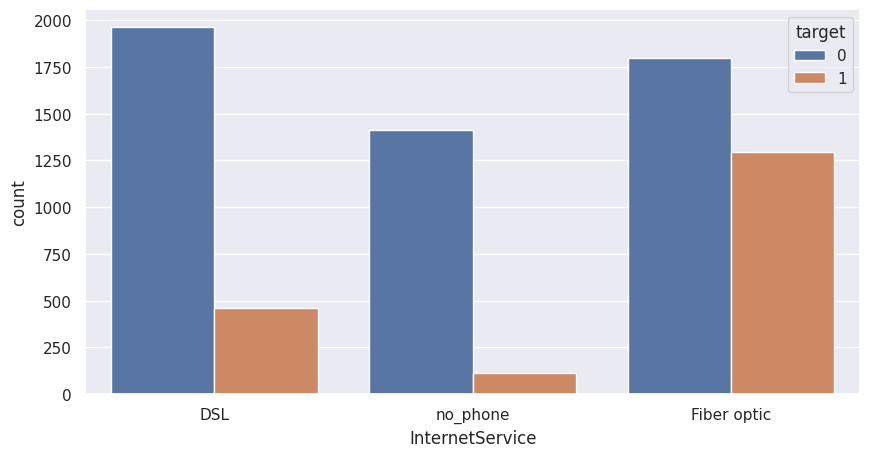


Корреляция Phik: 0.2
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: OnlineSecurity


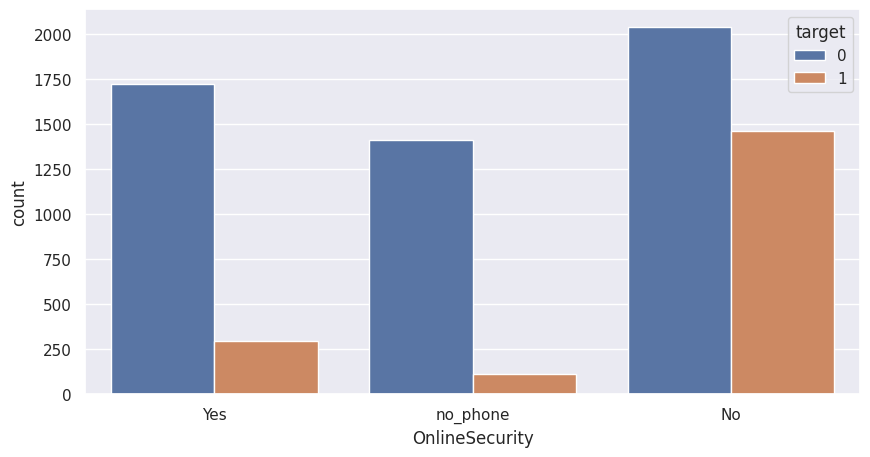


Корреляция Phik: 0.21
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: OnlineBackup


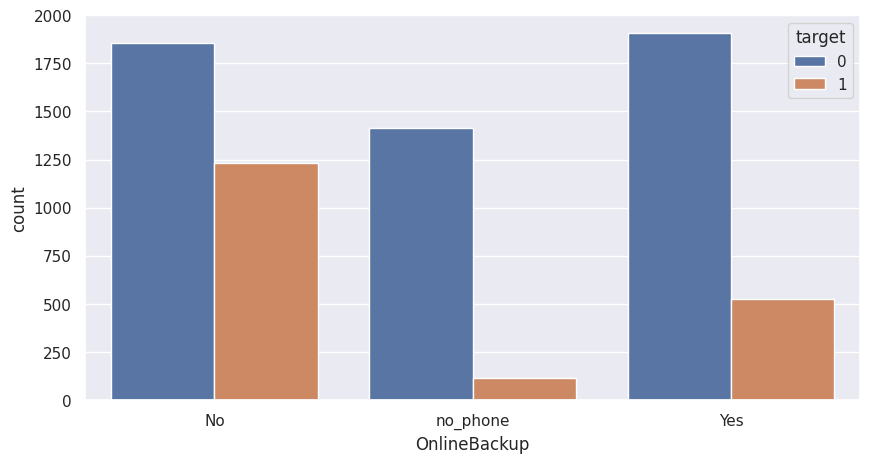


Корреляция Phik: 0.18
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: DeviceProtection


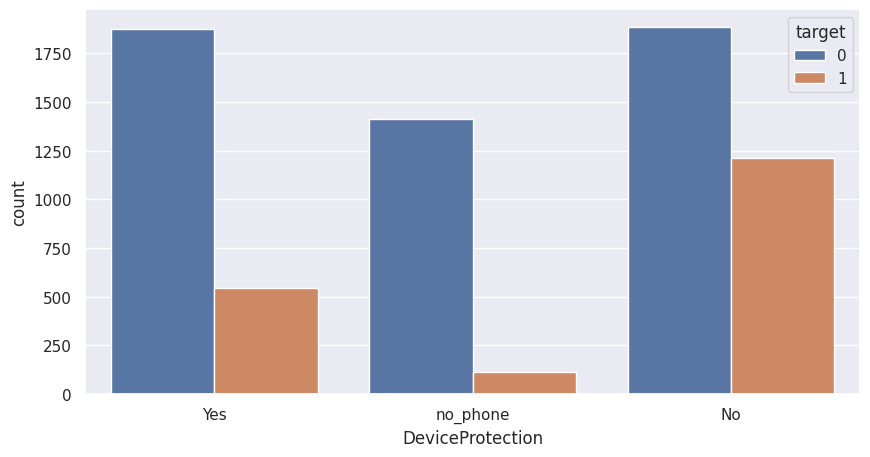


Корреляция Phik: 0.17
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: TechSupport


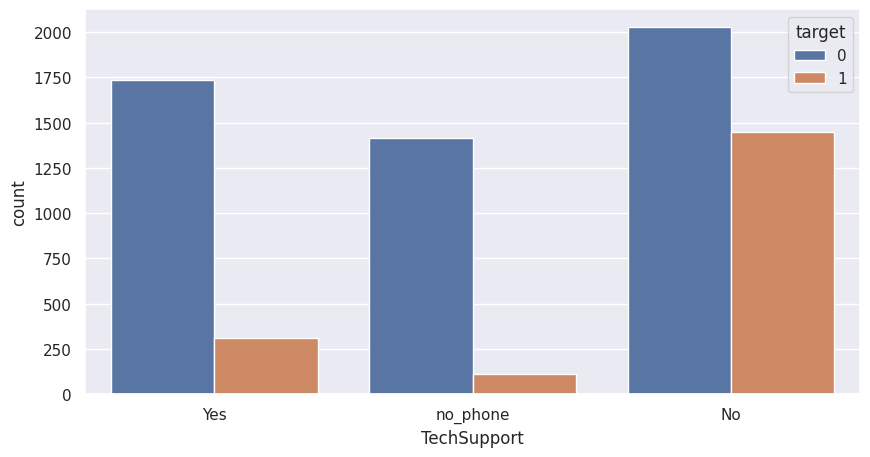


Корреляция Phik: 0.21
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: StreamingTV


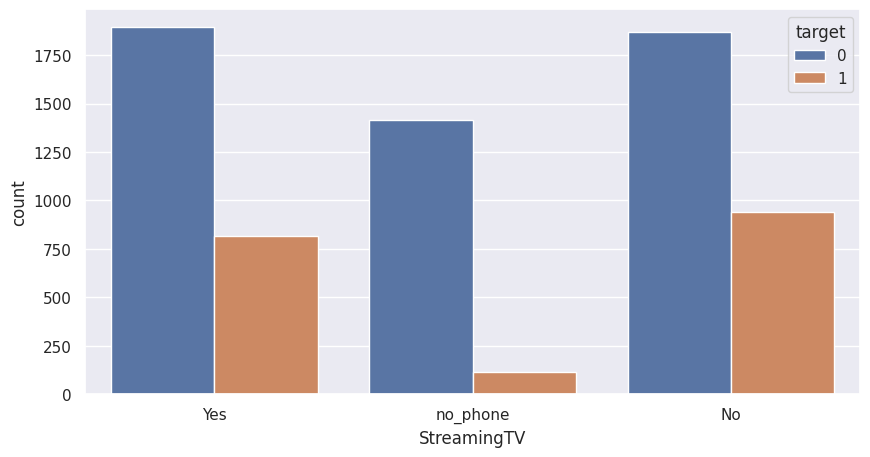


Корреляция Phik: 0.14
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: StreamingMovies


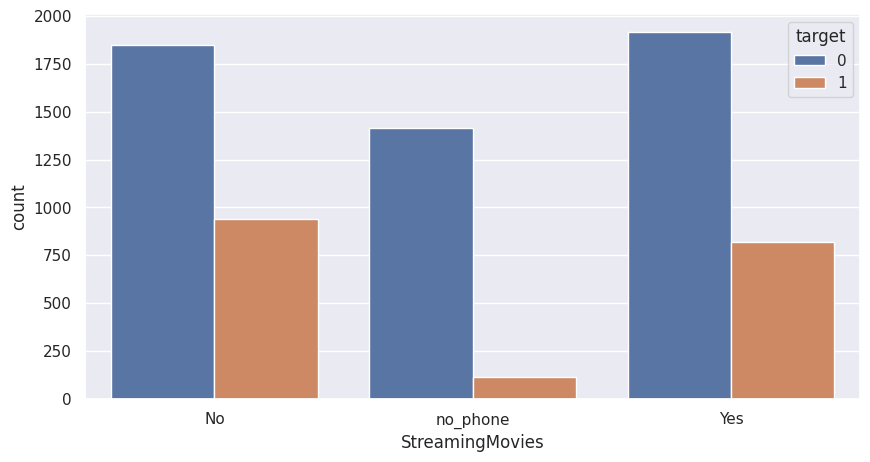


Корреляция Phik: 0.14
-----------------------------------------------------------------------------------------------
Зависимость целевого от признака: MultipleLines


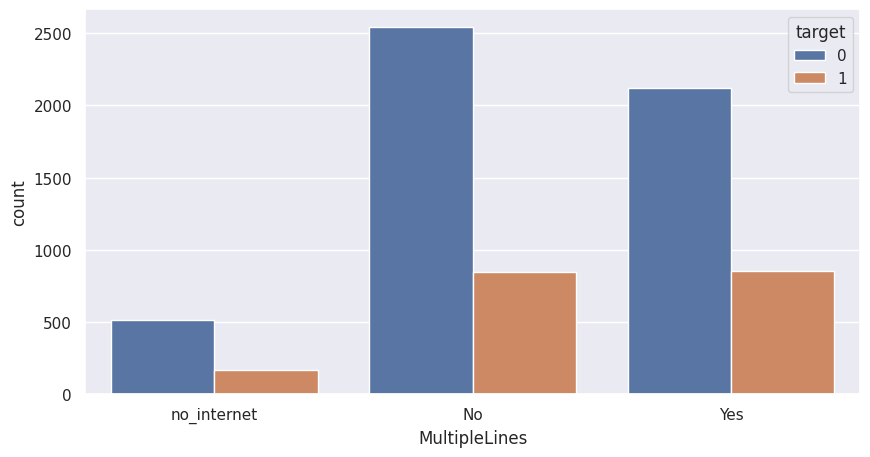


Корреляция Phik: 0.02
-----------------------------------------------------------------------------------------------


In [48]:
spread(data, ('MonthlyCharges','charges_ratio'))

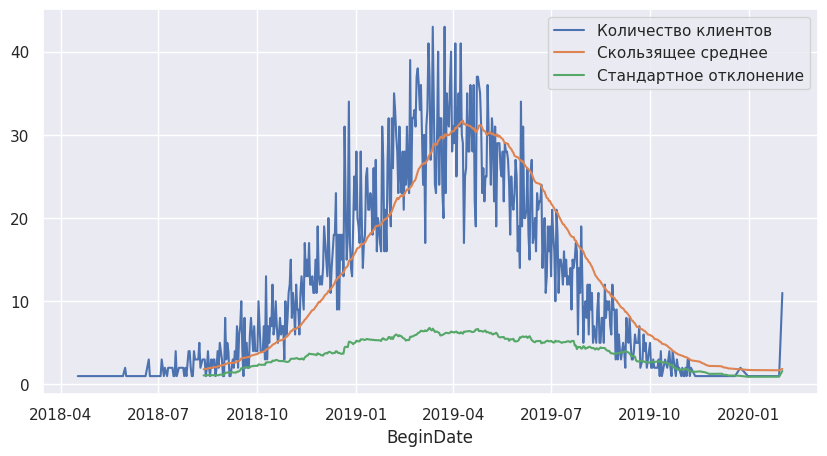

In [49]:
begin_pivot = contract.pivot_table(index='BeginDate', values='customerID', aggfunc='count')

begin_pivot['Скользящее среднее'] = begin_pivot['customerID'].rolling(50).mean()
begin_pivot['Стандартное отклонение'] = begin_pivot['customerID'].rolling(50).std()
begin_pivot.rename(columns={'customerID': 'Количество клиентов'}, inplace=True)
begin_pivot.plot()
plt.show()

Чаще всего контракт разрывают клиенты, которые платят за тариф раз в месяц. Клиент, который оплатил сразу на год, уже определился со своим выбором и не планирует расторгать договор посередине. Наибольшее количество контрактов подписано в середине 2019 года, существуют долгосрочные контракты, а информация о договорах актуальна только на 1 февраля 2020. Высокой корреляции нет, поэтому можно отказаться от этого признака.

В современном мире, многие операции происходят онлайн, поэтому не удивительно, что клиенты, получающие электронный рассчетный лист и оплачивающие онлайн, лидируют в отказах, и при этом показывают хорошую корреляцию.

Признак пола независим с целевой переменной, можно отказаться. Данных о возрасте нет, только отметка о работоспособности, может быть признак возраст дал бы лучшую корреляцию.

Пенсионеры чаще разрывают договоры, в отличии от остальных. возможно, они более подвержены телефонным обзвонам. Данный столбец имеет 23% слабую зависимость.

Неженатые люди чаще всего уходят от ТелеДома. Возможно, влияет непостоянное местопроживание. Зависимость схожа с предыдущим признаком.

Клиенты с детьми чаще разрывают договор с компанией. Может это свящано с целями экономии, или другие причины.

Мы наблюдаем слабую корреляцию между признаком InternetService и целевой переменой, однако люди, которые выбирают оптоволокно чаще всего отказываются от услуг компании. Возможно причина кроется в его скорости или других неудобствах.

Клиентов, которые пользуются вспомогательными услугам оператора можно объединить в этом пункте. Тех кто не выбирает блокировку сайтов, облачное хранилище, антивирус, выделенную линию поддержки большинство, они не обремены дополнительными способами удержания и чаще отказываются от новых предложений. Зависимости примерно одинаковы около 20.

Предложение стримингов судя по графикам данные независимы между собой. Если бы данные были свежие, послековидные, скорее всего итоги были бы другими, но скорее всего клиенты предпочитают подключаться напрямую, данную гипотезу можно поставить аналитикам.

Признак подключения телефона к нескольким линиям одновременно независим с целевым признаком, от него можно отказаться.

**Характерный портрет абонента**, который планирует отказаться от услуг связи:

**Это работоспособный человек с ежемесячной оплатой, получающий электронный рассчетный лист, с электронной оплатой, не состоящий в браке, без детей, с подключением через fiber-optic, без блокировки опасных сайтов, без облачного хранилища, без антивируса, без выделенной линии тех.поддержки, без стримингового тв, без каталога фильмов, который рассматривал или пользовался подключением телефона к нескольким линиям одновременно.**

### Итоговый выбор признаков

Посмотрим на корреляционную матрицу.

In [50]:
data_no_target = data.drop('target', axis=1)

/tmp/ipykernel_2246/347945517.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_no_target.corr(), annot=True)


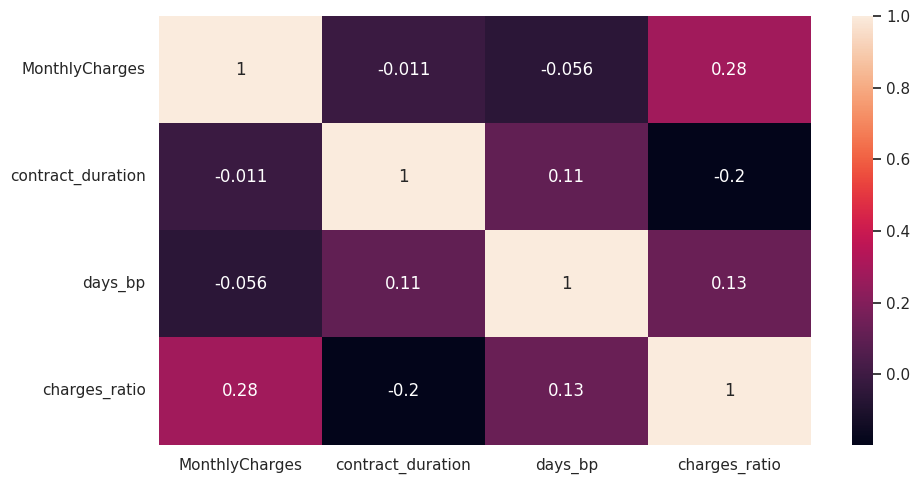

In [51]:
sns.heatmap(data_no_target.corr(), annot=True)
plt.tight_layout()
plt.show()

Судя по матрице, мультикорреляция не обнаружена среди непрерывных переменных. Так как мультикорреляция связана только с линейными зависимости, удалять их не рекомендуется.

In [52]:
del data_no_target

Проверим наши признаки с помощью встроенных методов (embedded methods) на основе случайного леса. Закодируем данные простым LabelEncoder, чтобы деревянные модели смогли с ними работать. Определим мультиколлениарность, и выберем признаки под удаление.

In [53]:
X_temp = data.drop('target', axis=1)
y_temp = data['target']

label_encoder = LabelEncoder()
to_encode = ['gender', 'SeniorCitizen', 'Dependents', 'StreamingMovies', 'OnlineBackup', 'Partner', 'Type', 'MultipleLines', 'PaymentMethod', 'TechSupport', 'InternetService', 'OnlineSecurity', 'PaperlessBilling', 'DeviceProtection', 'StreamingTV']
for column in to_encode:
    X_temp[column] = label_encoder.fit_transform(X_temp[column])

X_temp.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contract_duration,days_bp,charges_ratio
0,2,1,0,52.55,0,0,1,1,0,1,0,1,1,1,0,2,0,0,0.000000
1,2,0,3,20.25,1,0,0,1,2,2,2,2,2,2,2,0,0,0,0.000000
2,0,1,3,53.85,1,0,0,0,0,1,1,0,0,0,0,0,479,29,0.225783


In [54]:
#Независимые переменные
vif_test = X_temp

#Датафрейм VIF
vif_data = pd.DataFrame()
vif_data["feature"] = vif_test.columns

#Показатель VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(vif_test.values, i)
                          for i in range(len(vif_test.columns))]

print(vif_data)

              feature       VIF
0                Type  8.207499
1    PaperlessBilling  2.872130
2       PaymentMethod  3.074263
3      MonthlyCharges  8.965197
4              gender  1.966621
5       SeniorCitizen  1.366876
6             Partner  2.718033
7          Dependents  1.955108
8     InternetService  7.289935
9      OnlineSecurity  6.763053
10       OnlineBackup  6.602327
11   DeviceProtection  7.505073
12        TechSupport  7.450781
13        StreamingTV  8.340610
14    StreamingMovies  8.390145
15      MultipleLines  2.140043
16  contract_duration  9.991999
17            days_bp  7.504517
18      charges_ratio  1.483422


In [55]:
for column in ['days_bp', 'gender', 'Dependents']:
    del X_temp[column]

In [56]:
vif_test = X_temp

vif_data = pd.DataFrame()
vif_data["feature"] = vif_test.columns

vif_data["VIF"] = [variance_inflation_factor(vif_test.values, i)
                          for i in range(len(vif_test.columns))]

print(vif_data)

              feature       VIF
0                Type  2.974823
1    PaperlessBilling  2.868424
2       PaymentMethod  3.035862
3      MonthlyCharges  8.871610
4       SeniorCitizen  1.318340
5             Partner  2.184311
6     InternetService  7.272885
7      OnlineSecurity  6.744256
8        OnlineBackup  6.598493
9    DeviceProtection  7.501190
10        TechSupport  7.440978
11        StreamingTV  8.336694
12    StreamingMovies  8.383537
13      MultipleLines  2.135696
14  contract_duration  9.406586
15      charges_ratio  1.473231


Получили признаки со значением VIF меньше 10.

Cоздаем случайное дерево с нашими гиперпараметрами, чтобы посмотреть на важность текущих признаков.

,Importances
Features,
charges_ratio,0.202568
MonthlyCharges,0.163046
contract_duration,0.148270
Type,0.134903
OnlineSecurity,0.053764
PaymentMethod,0.046755
TechSupport,0.046582
InternetService,0.029626
OnlineBackup,0.029178


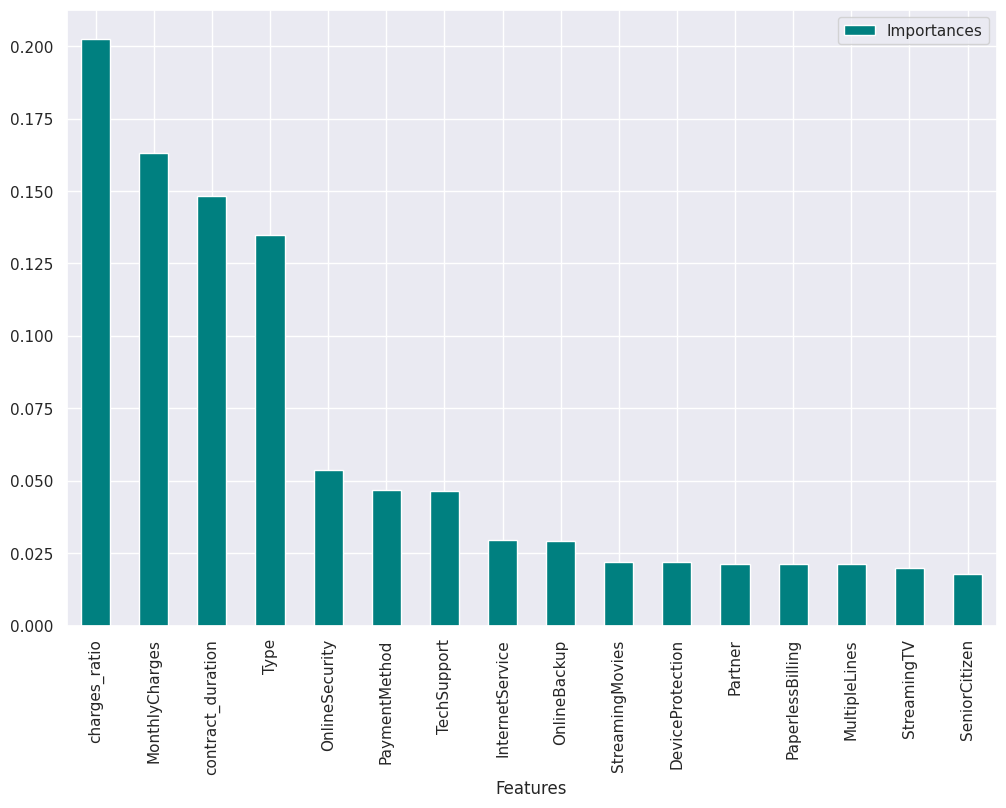

In [57]:
model = RandomForestClassifier(n_estimators=340, class_weight = 'balanced').fit(X_temp, y_temp)
importances = model.feature_importances_

final_df = pd.DataFrame({'Features' : pd.DataFrame(X_temp).columns, 'Importances' : importances})
final_df.set_index('Features', inplace=True)

final_df.sort_values(by='Importances', ascending=False, inplace=True)

final_df.plot.bar(color = 'teal', figsize=(12, 8));

display(final_df)

In [58]:
for column in ['days_bp', 'gender', 'Dependents']:
    del data[column]

In [59]:
del X_temp, y_temp

Определенно, у нас есть неудачные признаки, однако убирать их не будем, возможно они "стрельнут" при обучении.

### Вывод

По итогам исследовательского анализа были удалены несколько столбцов:
- days_bp - количество дней, которые остались до оплаты следующего периода тарифа. Не дал весомой информации - данные некоррелируют с нашим target, однако, несмотря на то, что хорошо себя показывает на пробной модели, признак считается важным.
- gender - доли людей, покинувших/не покинувших компанию были равными - данные не приносят никакой информации
- Dependents - необъективный признак, данные не приносят информации.


Мы имеет 4 сильных признака непрерывных переменных, которые не имеют мультикорреляцию - отношение общей суммы затрат к числу дней действия договора, расходы за месяц, тип контракта и его длительность.

В конечном итоге мы выбрали признаки, которые будем использовать для обучения. Перед нами не стоит задача временных рядов, поэтому не использовали даты как входные признаки модели. Так как мы сгенерировали признак «Длительность контракта абонента», то мы не будем использовать его одновременно с любыми другими производными признака BeginDate, так как это приведёт к утечке целевого признака.

В дальнейшем нам предстоит разделить данные на тренировочную и тестовую выборки (test_size = 0.25).
А также подготовить выборки для обучения, учитывая особенности выбранных моделей.

## Подготовка выборок для обучения моделей

In [60]:
data = data.reset_index(drop=True)

Генерация текстовых признаков

In [61]:
def text_features(row):
    indent = ' '
    test = []
    value = ''.join(row['Type'] + indent +
             row['PaperlessBilling'] + indent +
             row['PaymentMethod'] + indent +
             row['SeniorCitizen'] + indent +
             row['Partner'] + indent +
             row['InternetService'] + indent +
             row['OnlineSecurity'] + indent +
             row['OnlineBackup'] + indent +
             row['DeviceProtection'] + indent +
             row['TechSupport'] + indent +
             row['StreamingTV'] + indent +
             row['StreamingMovies'] + indent +
             row['MultipleLines'])

    return value

In [62]:
data['text'] = data.progress_apply(text_features, axis=1)

/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/7043 [00:00<?, ?it/s]

In [63]:
def text_embs(sentences):
    sentences = pd.Series(sentences)
    docs = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(sentences)]
    model = Doc2Vec(vector_size=128, min_count=1, epochs = 20)
    model.build_vocab(docs)
    model.train(docs, total_examples=model.corpus_count,epochs=model.epochs)
    model.save('d2v.model')
    vectors = [model.infer_vector((sentences[i].split())) for i in tqdm(range(0, len(sentences)))]
    return np.array(vectors)

In [64]:
text_features = text_embs(data['text'])

/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/7043 [00:00<?, ?it/s]

In [65]:
text_features.shape

(7043, 128)

Из описания клиента получили признаки, с размером выходного вектора = 128. Переходим к объединению.

Здесь нам нужно создать два пула признаков, одну для использования в деревянных моделях и бустинге, вторую - для всего остального.

In [66]:
X_boost = data[['charges_ratio', 'MonthlyCharges', 'contract_duration',
                                      'Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen',
                                      'Partner', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                                      'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'] ]
y_boost = data['target']
display(X_boost.head())
display(y_boost.head())

,charges_ratio,MonthlyCharges,contract_duration,Type,PaperlessBilling,PaymentMethod,SeniorCitizen,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0.000000,52.55,0,Two year,Yes,Bank transfer (automatic),No,Yes,DSL,Yes,No,Yes,Yes,Yes,No,no_internet
1,0.000000,20.25,0,Two year,No,Mailed check,No,No,no_phone,no_phone,no_phone,no_phone,no_phone,no_phone,no_phone,No
2,0.225783,53.85,479,Month-to-month,Yes,Mailed check,No,No,DSL,Yes,Yes,No,No,No,No,No
3,0.000000,80.85,0,Two year,No,Mailed check,No,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,0.543548,70.70,279,Month-to-month,Yes,Electronic check,No,No,Fiber optic,No,No,No,No,No,No,No


0    0
1    0
2    1
3    0
4    1
Name: target, dtype: int64

In [67]:
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop='first')

In [68]:
numerical_cols = ['charges_ratio', 'MonthlyCharges', 'contract_duration']
cat_cols = X_boost.columns[~(X_boost.columns.isin(numerical_cols))]

In [69]:
cat_cols_ohe = X_boost.columns[~X_boost.columns.isin(cat_cols)]
cat_cols_ohe = [x for x in cat_cols if x != 'target']

cat_cols_ohe

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [70]:
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(X_boost, y_boost,  test_size=0.25, random_state=RANDOM_STATE)

In [71]:
feature_arr = ohe.fit_transform(X_train_boost[cat_cols_ohe])
feature_labels = ohe.get_feature_names_out(cat_cols_ohe)

features_train = pd.DataFrame(feature_arr, columns = feature_labels)

features_train.shape

(5282, 24)

In [72]:
features_arr = ohe.transform(X_test_boost[cat_cols_ohe])
features_test = pd.DataFrame(features_arr, columns = feature_labels)

features_test.shape

(1761, 24)

In [73]:
features_train.columns[:5]

Index(['Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check'],
      dtype='object')

In [74]:
print(X_train_boost.shape, X_test_boost.shape)

(5282, 16) (1761, 16)


In [75]:
X_train_dt = pd.concat([X_train_boost[['charges_ratio', 'MonthlyCharges', 'contract_duration']], features_train.set_index(X_train_boost.index)], axis=1).copy()
X_test_dt = pd.concat([X_test_boost[['charges_ratio', 'MonthlyCharges', 'contract_duration']], features_test.set_index(X_test_boost.index)], axis=1).copy()

print(X_train_dt.shape)
print(X_test_dt.shape)

(5282, 27)
(1761, 27)


In [76]:
X = pd.DataFrame(np.c_[np.array(data[['charges_ratio', 'MonthlyCharges',
                                      'contract_duration']]), text_features])
y = data['target']
display(X.head())
display(y.head())

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,0.000000,52.55,0.0,0.015994,0.024238,-0.004185,0.069285,-0.010447,-0.009716,0.008677,...,0.046632,0.082834,0.059170,-0.065574,0.079477,-0.028296,0.105838,-0.055026,-0.040486,0.008227
1,0.000000,20.25,0.0,0.014396,-0.021598,-0.010071,0.018821,-0.002508,-0.075637,0.003481,...,0.017031,-0.001006,-0.011182,-0.008125,-0.026048,-0.021729,0.029322,-0.009500,0.012163,0.020469
2,0.225783,53.85,479.0,-0.025041,-0.002181,0.017063,0.028723,-0.035210,-0.052092,-0.009235,...,0.042999,-0.010366,0.008553,-0.029704,0.018387,-0.012786,0.028872,-0.047686,0.021822,-0.011594
3,0.000000,80.85,0.0,0.015780,-0.012718,0.021233,0.016614,-0.015308,-0.078536,-0.015239,...,0.034063,-0.041323,-0.017384,-0.050569,-0.001759,-0.003925,0.025097,-0.041766,0.024908,0.012198
4,0.543548,70.70,279.0,-0.034487,-0.003966,0.042345,0.059140,-0.048984,-0.096036,-0.007729,...,0.032111,-0.052026,-0.014328,0.036669,0.009356,-0.031024,0.000218,-0.038049,0.047884,-0.025599


0    0
1    0
2    1
3    0
4    1
Name: target, dtype: int64

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train[X_train.loc[:, 0:3].columns] = scaler.fit_transform(X_train[X_train.loc[:, 0:3].columns])
X_test[X_test.loc[:, 0:3].columns] = scaler.transform(X_test[X_test.loc[:, 0:3].columns])

X_train_torch = torch.FloatTensor(np.array(X_train))
X_test_torch = torch.FloatTensor(np.array(X_test))

y_train_torch = torch.FloatTensor(np.array(y_train))
y_test_torch = torch.FloatTensor(np.array(y_test))

In [78]:
print(X_train.shape, X_test.shape)
print('torch shape:', X_train_torch.shape, X_test_torch.shape)

(5282, 131) (1761, 131)
torch shape: torch.Size([5282, 131]) torch.Size([1761, 131])


In [79]:
def make_predict(model, train, tar, name, cv):
    score = cross_val_score(model, train, tar, cv=cv, scoring='roc_auc').mean().round(3)
    acc = cross_val_score(model, train, tar, cv=cv, scoring='accuracy').mean().round(3)
    return name, f'AUC-ROC: {score}, Accuracy: {acc}'

## Обучение моделей

Рассмотрим классы моделей:
- решающее дерево или случайный лес,
- бустинги,
- нейронные сети.

Найдем лучшую модель для прогноза оттока клиентов. Оценим её качество метрикой ROC-AUC. Выберем лучшую модель по значению метрики на кросс-валидации.
Для этого подберем значения как минимум двум гиперпараметрам хотя бы для одной модели. Лучше всего использовать методы автоматизированного подбора гиперпараметров, например, GridSearchCV.

### Нейронная сеть

In [80]:
bacc = BinaryAccuracy()
auc = AUROC(task='binary')
loss = nn.BCELoss()

model = nn.Sequential(
    nn.Linear(131, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid())

Разбиваем на 5 фолдов

In [81]:
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [82]:
metrics = {}
metrics['fold'] = []
metrics['loss'] = []
metrics['auc'] = []
metrics['accuracy'] = []

for fold, (train_index, val_index) in enumerate(kfold.split(X_train_torch)):

    train_X, val_X = X_train_torch[train_index], X_train_torch[val_index]
    train_y, val_y = y_train_torch[train_index], y_train_torch[val_index]

    for epoch in tqdm(range(1000)):
        loss_fold = []
        accur_fold = []
        auc_fold = []
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        optimizer.zero_grad()
        predictions = model.forward(train_X).flatten()
        loss_value = loss(predictions, train_y)
        loss_value.backward()
        optimizer.step()
        loss_fold.append(loss_value.cpu().detach().numpy())
        if epoch // 100 > 0:
            with torch.no_grad():
                model.eval()
                val_preds = model.forward(val_X).flatten()
                acc = bacc(val_preds, val_y).item()
                auc_roc = auc(val_preds, val_y).item()
                accur_fold.append(acc)
                auc_fold.append(auc_roc)

    metrics['fold'].append(fold)
    metrics['loss'].append(np.mean(loss_fold))
    metrics['accuracy'].append(np.mean(accur_fold))
    metrics['auc'].append(np.mean(auc_fold))

print('Cross-val AUC-ROC:', np.mean(metrics['auc']).round(3))
print('Cross-val accuracy:', np.mean(metrics['accuracy']).round(3))

/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Cross-val AUC-ROC: 0.838
Cross-val accuracy: 0.796


### Логистическая регрессия

In [83]:
make_predict(LogisticRegression(random_state=RANDOM_STATE, max_iter=3000), X_train, y_train, 'LogisticRegression', cv=5)

('LogisticRegression', 'AUC-ROC: 0.814, Accuracy: 0.785')

### AdaBoostClassifier

In [84]:
%%time
ada = AdaBoostClassifier(DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1, criterion='entropy'),
                   n_estimators=100, random_state=RANDOM_STATE, learning_rate=0.1)

make_predict(ada, X_train_dt, y_train_boost, 'AdaBoostClassifier', cv=5)

CPU times: user 5.11 s, sys: 95.6 ms, total: 5.2 s
Wall time: 5.19 s


('AdaBoostClassifier', 'AUC-ROC: 0.845, Accuracy: 0.795')

### Дерево решений

In [85]:
make_predict(DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1, criterion='entropy'),
             X_train_dt, y_train_boost, 'DecisionTreeClassifier', cv=5)

('DecisionTreeClassifier', 'AUC-ROC: 0.646, Accuracy: 0.731')

### Catboost

In [86]:
classes = np.unique(y_train_boost)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_boost)
class_weights = dict(zip(classes, weights))

In [87]:
#подбор гиперпараметров осуществлялся среди этих значений
'''parameters_cbr = {'max_depth': np.arange(4, 11),
                  'learning_rate':[0.0001, 0.001, 0.01, 0.1],
                  'iterations': [100,250,500,1000,1500,2000]}'''

"parameters_cbr = {'max_depth': np.arange(4, 11),\n                  'learning_rate':[0.0001, 0.001, 0.01, 0.1],\n                  'iterations': [100,250,500,1000,1500,2000]}"

In [88]:
model_cbr = CatBoostClassifier(logging_level='Silent', loss_function='Logloss')
parameters_cbr = {'max_depth': np.arange(4),
                  'learning_rate':[0.01],
                  'iterations': [1000]}
catboost_grid = GridSearchCV(model_cbr,
                             parameters_cbr,
                             cv=3,
                             scoring=['roc_auc', 'accuracy'],
                             refit = 'roc_auc').fit(X_train_dt, y_train_boost)

In [89]:
cv_results = pd.DataFrame.from_dict(catboost_grid.cv_results_)
best_idx = cv_results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = cv_results.loc[best_idx, 'mean_test_roc_auc']
acc = cv_results.loc[best_idx, 'mean_test_accuracy']
print(roc)
print(acc)

0.8513872017921938
0.8029152255089222


По результатам получилось следующее:

На первом месте модель CatBoost с результатом: ROC-AUC - 0.851, Accuracy: 0.802

На втором месте AdaBoost с результатом: ROC-AUC - 0.845, Accuracy: 0.795

На третьем месте нейронная сеть Net(131, 128, 128, 1) с результатом: ROC-AUC - 0.841, Accuracy: 0.798

На третьем месте LogReg с результатом: ROC-AUC - 0.816, Accuracy: 0.789

На пятом месте Дерево решений с результатом: ROC-AUC - 0.646, Accuracy: 0.731

Исследуем коэффициент регуляризации в логистической регрессии

In [90]:
%%time
for C in range(1, 10+1):
    model = LogisticRegression(random_state=RANDOM_STATE, C=C, max_iter=3000)
    print(f'C: {C}, ROC-AUC: {cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()}')

C: 1, ROC-AUC: 0.8139320747291222
C: 2, ROC-AUC: 0.8144576608176424
C: 3, ROC-AUC: 0.8145809843159544
C: 4, ROC-AUC: 0.814681302768965
C: 5, ROC-AUC: 0.8147779790772673
C: 6, ROC-AUC: 0.8147916866546876
C: 7, ROC-AUC: 0.8148737436775848
C: 8, ROC-AUC: 0.8148574192915458
C: 9, ROC-AUC: 0.8148656985866867
C: 10, ROC-AUC: 0.8148894003401305
CPU times: user 7.12 s, sys: 2.88 s, total: 10 s
Wall time: 6.05 s


С помощью регуляризационного коэффициента не удалось улучшить значение метрики ROC-AUC

### Вывод

Нейронная сеть не добирает необходимых баллов.
Лучше всех себя показывает CatBoost, в том числе и на дополнительном параметре точности. Будет ли необходимый результат на тесте, проверим его.

## Тестирование модели

Проверим качество лучшей модели на тестовой выборке. Значение метрики ROC-AUC должно быть не менее 0.85. Для интерпретируемости модели дополнительно выведем значение accuracy.


In [91]:
catboost_grid.best_params_

{'iterations': 1000, 'learning_rate': 0.01, 'max_depth': 3}

In [92]:
model = CatBoostClassifier(logging_level='Silent',
                           loss_function='Logloss',
                           iterations = 1000,
                           learning_rate = 0.01,
                           max_depth = 3).fit(X_train_dt, y_train_boost)
predictions = model.predict(X_test_dt)

In [93]:
y_pred_proba = model.predict_proba(X_test_dt)[:, 1]

auc_roc = roc_auc_score(y_test_boost, y_pred_proba)
accuracy = accuracy_score(y_test_boost, predictions)
print('AUC-ROC на тестовом наборе данных:', round(auc_roc, 2))
print('Accuracy на тестовом наборе данных:', round(accuracy, 2))

AUC-ROC на тестовом наборе данных: 0.85
Accuracy на тестовом наборе данных: 0.81


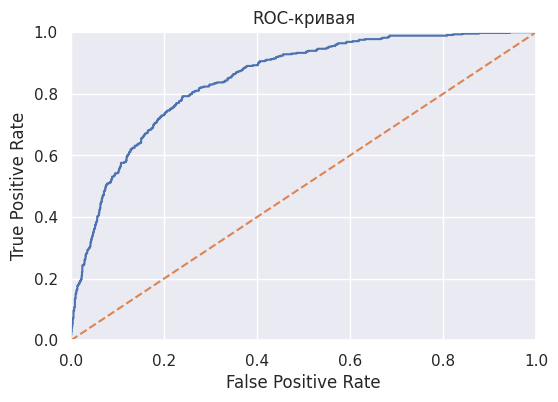

In [94]:
predicted_probalities = model.predict_proba(X_test_dt)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_boost, predicted_probalities)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Построим матрицу ошибок лучшей модели. Отобразим полноту и точность модели на графике.

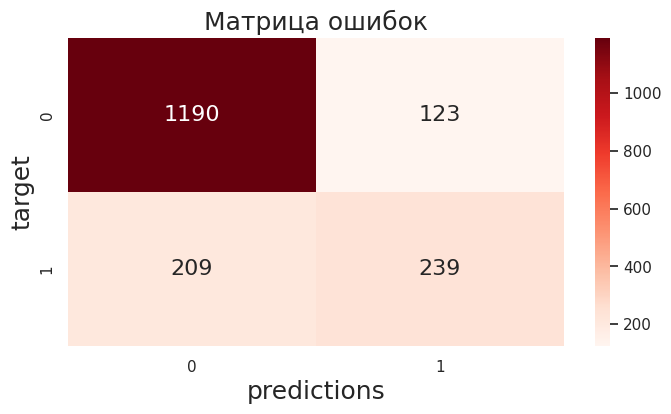

In [95]:
cm_cbc = confusion_matrix(y_test_boost, predictions)
cm_cbc_data = pd.DataFrame(cm_cbc,
                           index=['0', '1'],
                           columns=['0', '1'])

plt.figure(figsize=(8, 4))
sns.heatmap(cm_cbc, xticklabels=cm_cbc_data.columns, yticklabels=cm_cbc_data.index, annot=True, fmt='g', cmap="Reds", annot_kws={"size": 16})
plt.title("Матрица ошибок", size=18)
plt.xlabel('predictions', size=18)
plt.ylabel('target', size=18);

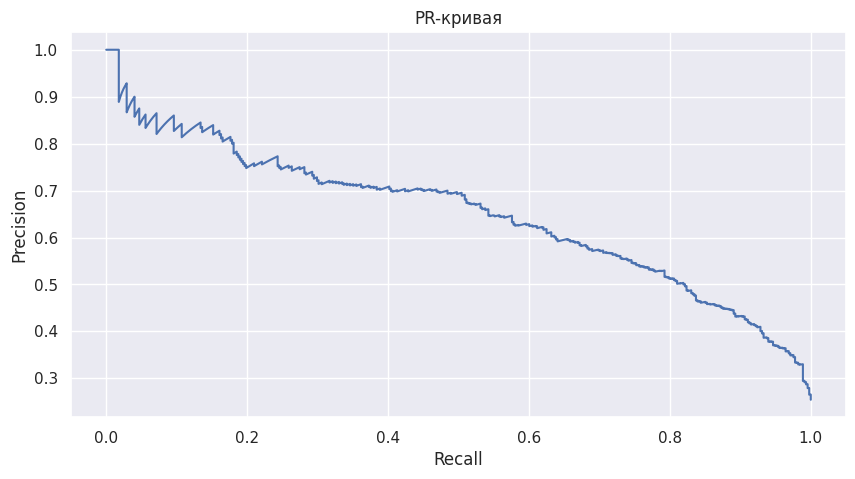

In [96]:
precision, recall, threshold = precision_recall_curve(y_test_boost, y_pred_proba)

plt.plot(recall, precision)

# Добавляем подписи осей и заголовок графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая')

plt.show()


Проанализируем важность основных входных признаков, влияющих на отток клиентов. Для одного из важных входных признаков проведем дополнительное исследование: покажем график зависимости входного и целевого признаков.

In [97]:
model.feature_importances_

array([2.14657129e+01, 3.91651760e+00, 2.31997169e+00, 5.91266966e+00,
       2.46731862e+01, 2.05826706e+00, 1.07747703e-01, 3.35978190e+00,
       1.89845625e-01, 7.08738920e-01, 7.87875272e-03, 1.51628401e+01,
       8.78630008e-01, 1.76893837e+00, 3.32475246e-01, 2.95718030e-01,
       9.41362346e-01, 1.99950093e-02, 1.52864270e+00, 1.86690825e+00,
       1.76194044e+00, 7.15203612e-01, 4.08719630e+00, 1.40064583e+00,
       3.24336885e+00, 8.90104484e-01, 3.85712430e-01])

In [98]:
indices = [i for i in range(0, len(model.feature_importances_)) if model.feature_importances_[i]>5]
indices

[0, 3, 4, 11]

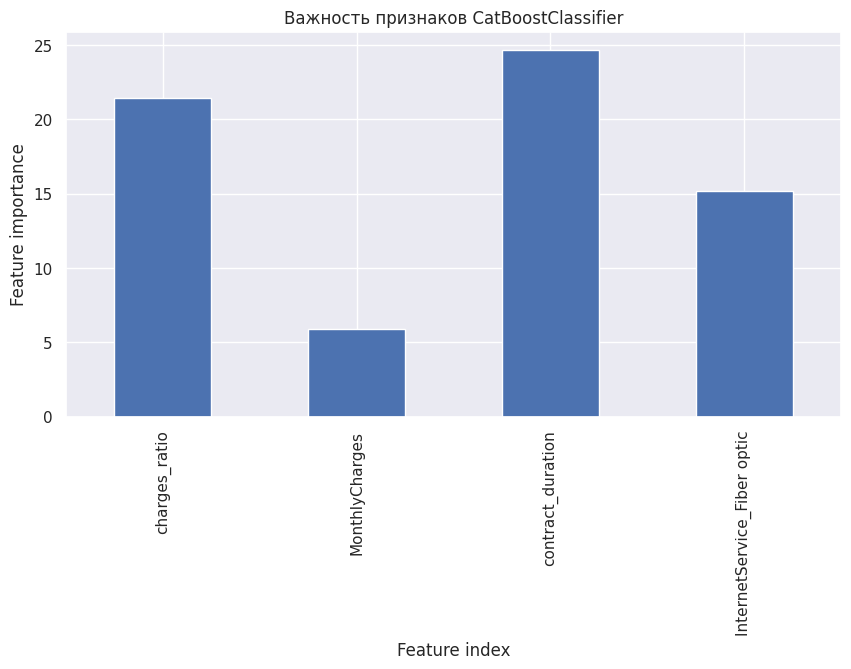

In [99]:
pd.Series(model.feature_importances_[indices],
          index=['charges_ratio', 'MonthlyCharges', 'contract_duration'] + list(X_train_dt.iloc[:, indices].columns[3:])).plot(kind='bar')

plt.title('Важность признаков CatBoostClassifier')
plt.xlabel('Feature index')
plt.ylabel('Feature importance')
plt.show()

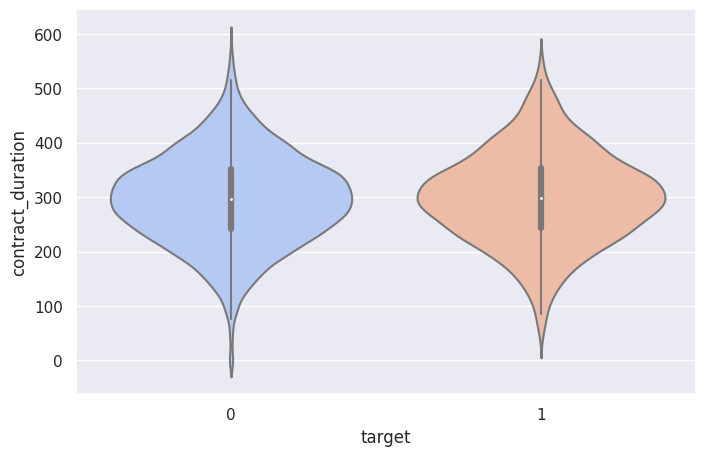


Корреляция Phik: 0.03
-----------------------------------------------------------------------------------------------



In [100]:
violentplot(data, 'contract_duration', 'target')

Самый весомый показатель для нашей модели - сгенерированный признак contract_duration длительность контракта. Как мы можем видеть на графике зависимости особой пользы от него быть не должно было, клиенты одинаково расстаются с компанией вне зависимости от длительности контракта, возможно в данных есть ошибка, и много незавершенных контрактов. Вне зависимости от периода договорных отношений ТелеДому необходимо необходимо оперативно активировать рекламную рассылку, устраивать промо-кампании для удержания клиентов.

## Вывод

Бустинг модель CatBoostClassifier очень хорошо показала себя на тестовых данных. По итогам предсказаний мы имеем AUC-ROC 0.85.

- 1190 True Negative (TN) - факт - нет, предсказание - нет
- 123 False positive (FP) - факт - нет, предсказание - да
- 232 False negative (FN) - факт - да, предсказание - нет
- 216 True positive (TP) - факт - да, предсказание - да

В нашем случае не так страшно получить ошибку первого рода, нежели второго.

- 67% от общего количества тестовых данных - правильное определение класса 0
- 12% - правильное предсказание класса 1
- 7% - мы неправильно угадываем класс 0, метка предсказания - 1
- 14% - мы неправильно идентифицируем человека, который не хочет уйти, хотя скоро разорвёт договор на оказание услуг.

Такие показатели удалось получить при использовании следующих гиперпараметров
- logging_level='Silent',
- loss_function='Logloss',
- iterations = 1000,
- learning_rate = 0.01,
- max_depth = 3.

В этом проекте была создана модель для прогнозирования оттока клиентов оператора связи

Проект включал следующие этапы:

- первичное изучение таблиц

- подключение к базе данных
- краткий обзор таблиц, доступных в базе данных (согласование их содержимого с бизнес-условием)

- предварительная обработка данных

- подготовка набора данных для обучения модели

- выбор признаков, участвующих в моделировании (+ добавление дополнительных признаков)

- работа с дубликатами и пропусками

- анализ исследовательских данных

- изучение количественных и категориальных признаков, анализ зависимостей в данных о целевом признаке, подготовка данных для модели прогнозирования оттока

- масштабирование количественных и кодирование категориальных признаков

- выделение тестовой выборки, обучение и поиск лучшей модели

Исходя из требований заказчика, мы сформулировали задачу ML
и выполнили целевые метрики.
Были обучены модели DecisionTree, Логистическая регрессия, CatBoost, AdaBoost, Neural Network, для некоторых выполнен подбор гиперпараметров.





**Способы для дальнейшего улучшения модели:**

- Можно попробовать создать признак прибыль от абонента в день, в кросс-валидации можно применить метод Stratify Kfold, а при разбиении на трейн и тест указать параметр stratify='target'.
        
- Удалить неважные для модели признаки.
    
- Можно провести более тонкую настройку гиперпараметров, к примеру, перебирать как max_depth, так и min_samples_leaf.

**Важные наблюдения и рекомендации**

- Среди тех, кто платит ежемесячно, доля отказов примерно равна, а среди выплат за год-два - максимальная
- Клиенты закрывают контракты без заключения новых договоров
- Отток более выражен для клиентов с минимальными ежемесячными тратами montly_charges
- Чаще всего клиенты закрывают контракты без интернета
- Все остальные дополнительные услуги не влияют на цель - пропорционально отказы везде одинаковы. Хотя косвенно они лежат в ежемесячных и общих платежах по контракту.

**Общие рекомендации**

- Поддержка пользователей по длительным контрактам до конца оплаченного периода
- Установление доверительных отношений с клиентами с самыми дешевыми контрактами (предоставление дополнительных опций и услуг, так как это мало влияет на отток)
- Предоставление клиентам без Интернета дополнительных услуг к уже существующим контрактам или/и их переориентация на новые контракты с другим набором опций